# Predicting the stringency of government measures against coronavirus using Reddit data

| Name                | Email                               | SNR     | ANR    |
|---------------------|-------------------------------------|---------|--------|
| Magdalena Kuyterink | m.v.kuyterink@tilburguniversity.edu | 1279765        |448037|
| Emilie Facon        | e.facon@tilbuguniversity.edu        | 2034446 | 782549 |

---



# Abstract

This project asks whether it is possible to predict the stringency of government measures against coronavirus in a given country, based on text from Reddit submissions in the subreddit of the country. 

All three models tested (naive Bayes, decision tree, and random forest) perform poorly for the given task. Our preferred model, the random forest with a tf-idf representation, has an overall accuracy of 46% only. 

Two explanations are possible. First, Redditors might have concerns unrelated to coronavirus, meaning that our prediction task can only capture noise. Alternatively, it is possible that the models used were not adequate or effective enough, and using better models might improve the results.
Further research based on news data sets could inform us on which explanation is more likely.

---


# Set up

In [0]:
# Mount drive - Skip if not using Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Replace directory by path of the directory

directory = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## Install and load libraries

# Install libraries

!pip install psaw 
!pip install langdetect
!pip install vaderSentiment
!pip install jenkspy

## Load libraries

# Disable future warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Basic libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Dates
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
from datetime import datetime

 # Timing and dealing with files
from time import time, sleep
from sys import stdout
import os
from os.path import isfile, join
import pickle

# Scipy
from scipy.stats import ttest_ind
from scipy.stats.stats import pearsonr

# Natural breaks algorithm
import jenkspy

# PSAW
from psaw import PushshiftAPI

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier

# Imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Nltk
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer # Non-English stemmer
from nltk.stem import PorterStemmer # English stemmer

# Text analysis
import re 
from wordcloud import WordCloud
from langdetect import DetectorFactory, detect
from collections import Counter

# Lexicon-based methods
from textblob import TextBlob 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

pd.options.display.max_colwidth = 50

print("Complete.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Complete.


In [0]:
## Formatting

# Generate a variable to turn off parts of the code
# that is for cells that take very long to run, so the code doesn't run

toggle_off = False # For code that we won't run at all in this notebook
toggle_on = True # For code that we will run only once at the end

# Set graph style

plt.style.use('ggplot')
mpl.rcParams['legend.facecolor'] = '#FFFFFF'
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['figure.figsize'] = (6, 4)
my_format = mdates.DateFormatter('%-d %b') # Format date index: "1 January"
months = mdates.MonthLocator()  # Format ticks: Every month

---

# Contents

1. Introduction
  * Motivation
  * Research questions
  * Assumptions and methods
  * Answers to research questions

2. Data
  * OxCGRT data set
  * Reddit data set

3. Analysis and results
  * Sentiment of Reddit submissions and stringency of government measures
  * Predicting mentions of coronavirus using other words in Reddit submissions
  * Predicting stringency of government measures using Reddit submissions
    * Naive Bayes classifier
    * Decision tree
    * Random forest

4. Sensitivity analysis
  * Comparison: Naive Bayes vs decision tree vs random forest
  * Alternative target variables
  * Discussion

5. Conclusion

----


# 1. Introduction 

## 1.1. Motivation 

<center>
<img src="https://specials-images.forbesimg.com/imageserve/5e8a44b2a8dda2000749f3aa/960x0.jpg" alt="Who led the digital transformation of your company?" width="350"/>

Source: [Forbes](https://www.forbes.com/sites/blakemorgan/2020/04/05/is-covid-19-forcing-your-digital-transformation-12-steps-to-move-faster/#5e25d520617b)
</center>

The recent Covid-19 pandemic has increased the speed of digitisation and the adoption of new technologies. 
Indeed, social distancing measures aimed at limiting the spread of the virus have forced people to adopt different forms of communication to stay in touch with loved ones. 
Big tech companies such as Facebook and Alphabet have emerged stronger from this crisis, as both advertisers and consumers move to online platforms to conduct their daily activities ([The Economist](https://www.economist.com/leaders/2020/04/04/big-techs-covid-19-opportunity)). 

In particular, the coronavirus pandemic has led the public to move to online platforms to voice their opinions and concerns, further strengthening the position of social media and discussion websites, which were already an important source of news for many Americans ([Forbes](https://www.forbes.com/sites/petersuciu/2019/10/11/more-americans-are-getting-their-news-from-social-media/)). However, the information posted on these platforms is not always reliable, and "fake news" has become a major concern in recent years. These online platforms have also been criticised for being "echo chambers" ([The Guardian](https://www.theguardian.com/science/blog/2017/dec/04/echo-chambers-are-dangerous-we-must-try-to-break-free-of-our-online-bubbles)), online bubbles disconnected from the real world. It is important to analyse the content of these platforms to check whether these concerns are justified. 

In this project, we use data from [Reddit](https://reddit.com/), one of the most popular discussion websites in the world. We examine the relationship between the content of submissions posted on country-specific subreddits, and the strength of the government measures against coronavirus in this specific country. We hypothesise that if it is possible to easily predict the level of government measures from the text, then this would provide evidence that Reddit is not a "bubble" cut from the rest of the world, as offline events matter. However, our results show that it is difficult to predict the level of government measures using three different models (naive Bayes, decision tree, random forest). Two explanations are possible. First, Redditors might have concerns that have no relation to coronavirus, meaning that prediction will only capture noise. Alternatively, it is possible that the models used were not adequate or effective enough, and using better models might improve the results.

## 1.2. Research questions

The research questions are:
1. Is the sentiment of Reddit submissions significantly different when government measures are stringent, compared to when they are not?
2. Is it possible to predict whether a submission mentions coronavirus based on other words in the submission? Which words are associated with mentions of coronavirus?
3. Is it possible to predict the level of government measures using Reddit submissions?

## 1.3. Assumptions and methods

We obtain a collection of Reddit submissions and comments using [PSAW](https://psaw.readthedocs.io/en/latest/), the Python [Pushshift](https://pushshift.io/) API Wrapper.
We collect submissions from 1st January 2019 to 30th April 2020, and focus the analysis on the period starting on 1st January 2020. 

The data on government measures against coronavirus comes from the [Oxford COVID-19 Government Response Tracker (OxCGRT)](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker). The main variable of interest is "Stringency", which describes the stringency of government measures against coronavirus, ranging from 0 (no measures) to 100 (maximum measures). 

First, we focus on the sentiment analysis task using two different lexicon-based tools: [TextBlob](https://textblob.readthedocs.io/en/dev/) and [VADER](https://pypi.org/project/vader-sentiment/) (Valence Aware Dictionary and sEntiment Reasoner). These approaches produce a valence score using a dictionary of words labelled positively or negatively. 
We also considered using a supervised learning approach, but failed to find labelled data of Reddit submissions which could be used as a training set. We did find a labelled Twitter data set, and first wanted to do the analysis on Twitter data instead of Reddit data, but our request for access to the Twitter API is still under review and has not been answered. 

Secondly, for the prediction tasks, we pre-process the data to obtain word tokens, and use either a bag-of-words and a tf-idf (term frequency-inverse document frequency) representation to obtain numerical features that can be used in different models. 
Given that these representations only focus on word frequency, a key assumption of these approaches is that word order can be ignored when analysing text data.

The first prediction task (predicting mentions of coronavirus using words in a submission) acts as a simple introduction to our approach. We use the multinomial naive Bayes classifier from scikit-learn, with both bag-of-words and tf-idf featurisation methods. We choose this approach as the coefficients have an interpretation, such that we can easily identify which words are most associated with mentions of coronavirus.
Note that this is only a prediction task and cannot be interpreted causally.

The main focus of the project is to see whether it is possible to predict the level of government measures from Reddit submissions in particular country subreddits.
After pre-processing and transforming the data into bag-of-words or tfidf, we apply three different methods: naive Bayes, decision trees, and random forests. 
We use three different categorical dependent variables: "phase" (which is subjectively decided for each country based on the evolution of their government measures), "category" (with one category for each quartile of stringency), and "stay at home" (which is equal to 1 if there are some stay-at-home requirements in place, and 0 otherwise). Finally, we compare the performance of the different models on the different dependent variables, and conclude with some recommendations for future research. 

## 1.4. Answers to research questions

This subsection presents our main findings.

1. **There does not seem to be a clear relationship between the sentiment of Reddit submissions and the stringency of government measures.** Submissions tend to be more negative when stringency is higher, but the magnitude of the correlation coefficient is small: -0.036 or -0.034 depending on the measure of polarity. The opposite relationship holds for comments, with coefficients of 0.008 and 0.005. Overall, although these coefficients are statistically significant at the 1% level given the large sample size, their economic significance is negligible. Thus, it seems that the stringency of government measures did not have a direct impact on the sentiment of Reddit posts.

2. **Using the naive Bayes classifier, it seems difficult to predict whether a submission mentions coronavirus based on other words in the submission.** Accuracy is not a representative metric in this case, as 93% of the data belongs to one class. Looking at the confusion matrix, our preferred model achieves a rate of true positives of 89% and true negatives of 55%. 
The words with the largest coefficients are the strongest predictors of mentions of coronavirus. Among them are: "case" (in the phrase "number of confirmed cases" for example), "test", "virus", "19" (as in "COVID-19").

3. **It is difficult to accurately predict the strignency of government measures based on Reddit data.** Our best model, the random forest classifier using a tf-idf representation, has an accuracy of 46%, which is relatively low.

# 2. Data

After reviewing various data sources, we decided to use submissions from Reddit to construct our features, and data from the Oxford COVID-19 Government Response Tracker (OxCGRT) to create our target variable. 
All data is publicly available and can be retrieved using an API. Each data set will be seperately described in the following subsections.


## 2.1. OxCGRT data set: stringency of government measures

This section presents our first data set: the OxCGRT data set. We also present some global and cross-country summary statistics. Then, we focus on the Netherlands, and present the evolution of key variables for the country. Finally, we transform the continuous stringency index into a categorical variable we call "phase", which will be useful later in the analysis.

### 2.1.1. Presentation of the data set

The first data set we use is the [Oxford COVID-19 Government Response Tracker (OxCGRT)](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker), which can be accessed through an API or downloaded as a csv file. 

The data is updated on a regular basis and provides reliable and comparable information on policy responses around the world. 
It contains information on confirmed cases of coronavirus and deaths, as well as 17 indicators of government responses (such as closure policies, economic policies, and health system policies). These are then aggregated into a stringency index. 

We restrict our focus to the time period up until 1st May 2020 and to a list of 11 European countries, namely: Belgium, Canada, France, Germany, Ireland, Italy, the Netherlands, Spain, Switzerland, the United Kingdom, and Sweden. 
We chose countries that were relatively similar in terms of economic and human development, and yet have had been impacted very differently by coronavirus. We also took into account our familiarity with the country's culture, political system, and language, when making our selection.

In [0]:
country_list = ['Belgium', 'Canada', 'France', 'Germany', 'Ireland', 
                'Italy', 'Netherlands', 'Spain', 'Switzerland', 'United Kingdom',
                'Sweden']

capitalise_country = {
    'belgium': 'Belgium',
    'canada': 'Canada',
    'france': 'France',
    'germany': 'Germany',
    'ireland': 'Ireland',
    'italy': 'Italy',
    'netherlands': 'Netherlands',
    'spain': 'Spain',
    'switzerland': 'Switzerland',
    'uk': 'United Kingdom',
    'sweden': 'Sweden'
}

We use two different versions of the data set. 
The main data set is the latest version of the csv file available on 9th June 2020. We also use the latest version of the csv file available on 4th May 2020 to calculate the stringency phases.

In the next cell, we import the data set and show the first few columns. 

In [0]:
# Import Oxford data on stringency of government measures

path = "drive/My Drive/Data/"

gov_measures = pd.read_csv(path + "OxCGRT_June.csv")

gov_measures['Date'] = pd.to_datetime(gov_measures['Date'], format='%Y%m%d')
gov_measures = gov_measures[gov_measures['Date'] < '2020-05-01'] # Limit to 1st May - excluded

gov_measures.head()

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The `StringencyIndex` variable is calculated based on the policy indicators C1-C8 and H1. It goes from 0 to 100, with 100 representing the highest stringency of policies.

The `StringencyIndexForDisplay` variable is a smoothed value of `StringencyIndex`, which ignores missing data. It was created to provide a stabilised value for display purposes. This is the key variable of interest in the rest of the analysis.  

More information about the calculation method is available on the [OxCGRT website](https://www.bsg.ox.ac.uk/sites/default/files/Calculation%20and%20presentation%20of%20the%20Stringency%20Index.pdf).

### 2.1.2. Global summary statistics

We perform some summary statistics for the key variables by pooling all countries in the OxCGRT data set, to  get a sense of the global impact of the coronavirus pandemic.



In [0]:
# Summary statistics 

gov_measures['NewCases'] = gov_measures.groupby('CountryName')['ConfirmedCases'].diff()
gov_measures['NewDeaths'] = gov_measures.groupby('CountryName')['ConfirmedDeaths'].diff()

# Total cases and deaths globally

total_cases = gov_measures[gov_measures['Date'] == '2020-04-30']['ConfirmedCases'].sum()
total_cases = int(total_cases)
print("Total number of confirmed cases, as of 30th April 2020:", total_cases)

total_deaths = gov_measures[gov_measures['Date'] == '2020-04-30']['ConfirmedDeaths'].sum()
total_deaths = int(total_deaths)
print("Total number of confirmed deaths, as of 30th April 2020:", total_deaths)

Total number of confirmed cases, as of 30th April 2020: 3126749
Total number of confirmed deaths, as of 30th April 2020: 227098


By 30th April 2020, the coronavirus pandemic had affected more than 3 million people worldwide, and caused over 200,000 deaths.

In [0]:
# Countries with most confirmed cases

countries_ranked = gov_measures[gov_measures['Date'] == '2020-04-30'][['CountryName', 'ConfirmedCases', 'ConfirmedDeaths']]

countries_ranked['CasesRank'] = countries_ranked['ConfirmedCases'].rank(ascending = False)
countries_ranked['DeathsRank'] = countries_ranked['ConfirmedDeaths'].rank(ascending = False)

countries_ranked = countries_ranked[['CountryName', 'CasesRank', 'ConfirmedCases', 'DeathsRank', 'ConfirmedDeaths']]
countries_ranked = countries_ranked.sort_values('ConfirmedCases', ascending = False)

countries_ranked.head(10)

,CountryName,CasesRank,ConfirmedCases,DeathsRank,ConfirmedDeaths
26452,United States,1.0,1039909.0,1.0,60966.0
8283,Spain,2.0,215183.0,4.0,24543.0
13005,Italy,3.0,203591.0,2.0,27682.0
9404,United Kingdom,4.0,165221.0,3.0,26097.0
6843,Germany,5.0,159119.0,7.0,6288.0
9084,France,6.0,128442.0,5.0,24087.0
25652,Turkey,7.0,117589.0,12.0,3081.0
21330,Russia,8.0,99399.0,20.0,972.0
12365,Iran,9.0,93657.0,8.0,5957.0
5083,China,10.0,83944.0,11.0,4637.0


As of 30th April 2020, the United States was the country with the highest number of coronavirus cases, with over 1 million confirmed cases. It was also the highest in terms of confirmed deaths from coronavirus, with over 60,000 deaths. 
Other countries that were also highly affected on 30th April include Spain, Italy, the United Kingdom, Germany, France, Russia, Iran, and China. 

### 2.1.3. Cross-country summary statistics

In the subsequent analysis, we apply a cross-country comparison for our selected countries. 

In [0]:
## Subsample of 10 countries

# Get the subsample of 10 countries that are in country_list
subsample = countries_ranked[countries_ranked['CountryName'].isin(country_list)]

# Rearrange country_list so that it is ordered following CasesRank (useful later)
country_list = subsample['CountryName']

# Display subsample
subsample

,CountryName,CasesRank,ConfirmedCases,DeathsRank,ConfirmedDeaths
8283,Spain,2.0,215183.0,4.0,24543.0
13005,Italy,3.0,203591.0,2.0,27682.0
9404,United Kingdom,4.0,165221.0,3.0,26097.0
6843,Germany,5.0,159119.0,7.0,6288.0
9084,France,6.0,128442.0,5.0,24087.0
4603,Canada,12.0,51587.0,13.0,2996.0
1881,Belgium,13.0,47859.0,6.0,7501.0
18609,Netherlands,14.0,38802.0,10.0,4711.0
4763,Switzerland,17.0,29324.0,16.0,1407.0
23890,Sweden,21.0,20302.0,14.0,2462.0


The countries are ranked according to the severity of the outbreak, as measured with the number of total confirmed cases and total number of confirmed deaths on 30th April. 
We see that Spain, Italy, the United Kingdom, and France, have a high number of both cases and deaths. 

The ranking based on number of cases can diverge from the ranking based on confirmed deaths, and may be informative about the government measures taken. For example, Germany ranked 4th in number of confirmed cases, but only 7th in terms of confirmed deaths. This might be indicative of different testing policies across countries, which is why it is important to consider both sets of variables. 

In the next cell, we define a function which creates two subplots automatically. We will then call this function first on the confirmed cases and deaths variables, secondly on the new cases and deaths variables, to visualise the evolution of the pandemic over time.

In [0]:
# Define function to plot cases and deaths

def two_subplots(var1, title1, var2, title2, rolling = 0):

  f, (a1, a2) = plt.subplots(1, 2)

  f.set_figheight(5)
  f.set_figwidth(10)

  new_df = df.pivot(index='Date', columns='CountryName', values=var1)
  new_df = new_df[country_list] # Reorder
  if rolling != 0:
    new_df = new_df.rolling(rolling).mean()
  for country in list(new_df):
    a1.plot(new_df[country], label = country)
  a1.legend(title = "")
  a1.set_title(title1)

  a1.xaxis.set_major_formatter(my_format)
  a1.xaxis.set_major_locator(months)
  a1.xaxis.set_minor_locator(months)

  new_df = df.pivot(index='Date', columns='CountryName', values=var2)
  new_df = new_df[country_list] # Reorder
  if rolling != 0:
    new_df = new_df.rolling(rolling).mean()
  for country in list(new_df):
    a2.plot(new_df[country], label = country)
  a2.legend(title = "")
  a2.set_title(title2)

  a2.xaxis.set_major_formatter(my_format)
  a2.xaxis.set_major_locator(months)
  a2.xaxis.set_minor_locator(months)

  f.autofmt_xdate()

  plt.tight_layout()
  plt.show()

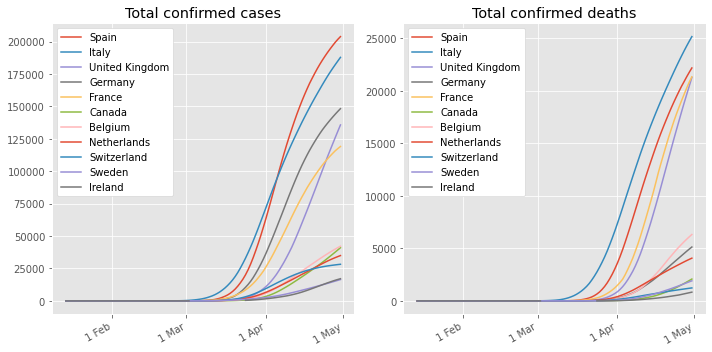

In [0]:
# Confirmed cases and deaths

df = gov_measures[gov_measures['CountryName'].isin(country_list)]
two_subplots('ConfirmedCases', 'Total confirmed cases', 
             'ConfirmedDeaths', 'Total confirmed deaths', 14)

We see that the evolution of both confirmed cases and confirmed deaths have the same shape, although the scale is different.

Among the highly affected countries in our sample, the spread of the epidemic seems to have slowed in Spain, Italy, Germany, and France, as the curves had started to flatten out by the end of April. 

However, the curve for the United Kingdom remained upward sloping even at the end of the period, suggesting that the virus was showing no signs of slowing down its spread in that country.

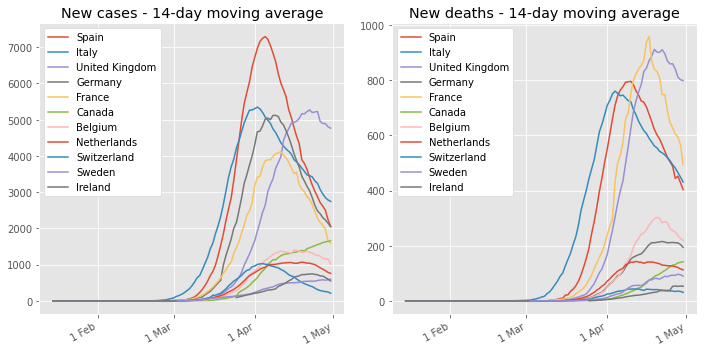

In [0]:
# New cases and deaths

df = gov_measures[gov_measures['CountryName'].isin(country_list)]
two_subplots('NewCases', 'New cases - 14-day moving average', 
             'NewDeaths', 'New deaths - 14-day moving average', 14)

The graphs for new cases and deaths confirm that the spread of the virus has started to slow for most countries.

Italy was the first country in our sample to reach its peak in daily new cases in early April, followed by Spain, Germany, and France. A similar parttern holds for daily new deaths, although delayed by a few days or weeks.

The United Kingdom seems to have managed to slow down the rate of increase of the virus, with new cases and deaths peaking in late April. Thus, we expect that the curves of cumulative cases and deaths (shown in the cell above this) have already started to flatten for the United Kingdom, even though it was not clearly visible from the cumulative graphs.

In the next cell, we plot the stringency variable to visualise government responses across the world over time.

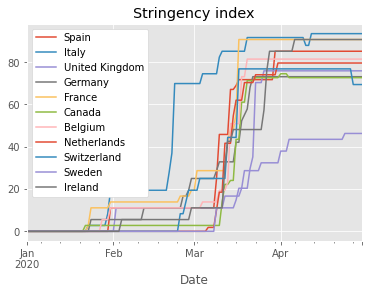

In [0]:
## Stringency

df = gov_measures[gov_measures['CountryName'].isin(country_list)]
stringency = df.pivot(index='Date', columns='CountryName', values='StringencyIndexForDisplay')
stringency = stringency[country_list]

# One plot with all countries

stringency.plot()
plt.legend(title = "")
plt.title("Stringency index")
plt.show()

Most countries have started imposing some restriction measures by the end of January. However, it is not until around mid-March that most countries have drastically increased the measures aimed at reducing the spread of coronavirus.

There seems to be two outliers in our sample. First, Italy has started imposing stringent measures much earlier than other countries, reaching a stringency index of about 70 by the end of February. Secondly, Sweden seems to have relatively mild measures, with an index at around 50 even by the end of April, compared to over 70 for all other countries in our sample.

### 2.1.4. Detailed statistics for the Netherlands

We provide more detailed statistics and graphs for the Netherlands. 

In [0]:
# Create data frame for the Netherlands

netherlands_measures = gov_measures[gov_measures['CountryName'] == 'Netherlands']
netherlands_measures = netherlands_measures[['Date', 'ConfirmedCases', 'NewCases', 'ConfirmedDeaths', 'NewDeaths', 'StringencyIndexForDisplay']]
netherlands_measures['Week'] = netherlands_measures['Date'].dt.week
round(netherlands_measures.groupby(['Week']).mean().tail(12))

,ConfirmedCases,NewCases,ConfirmedDeaths,NewDeaths,StringencyIndexForDisplay
Week,,,,,
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,0.0,0.0
10,71.0,26.0,0.0,0.0,1.0
11,550.0,110.0,5.0,2.0,32.0
12,2198.0,382.0,66.0,18.0,67.0
13,6674.0,876.0,378.0,72.0,74.0
14,13696.0,981.0,1189.0,145.0,79.0
15,20865.0,1112.0,2219.0,142.0,80.0


The table above shows, for each week, the mean confirmed cases, new cases, confirmed deaths, new deaths, and stringency index. Note that these are not weekly numbers, but averages for each week.

We can see that the number of new cases and deaths has been decreasing in the last few weeks before 30th April. 
By the end of the period, there were about 40,000 cases and almost 5,000 deaths from coronavirus in the Netherlands.

We can also notice the very rapid increase in stringency: it went from an average of 1 to 67 within two weeks, reflecting the short time frame within which the government has decided on implementing measures. 

In the next cell, we plot the total number of cases and deaths, and the number of new cases and deaths, for the Netherlands only.

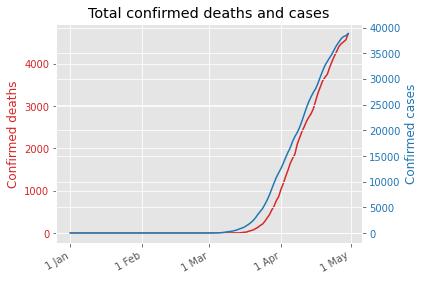

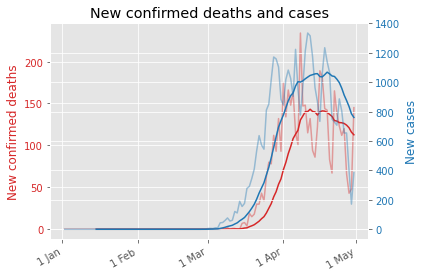

In [0]:
# Plot confirmed deaths and cases

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Confirmed deaths', color=color)
ax1.plot(netherlands_measures['Date'], netherlands_measures['ConfirmedDeaths'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Confirmed cases', color=color)  # we already handled the x-label with ax1
ax2.plot(netherlands_measures['Date'], netherlands_measures['ConfirmedCases'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.xaxis.set_major_formatter(my_format)
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_minor_locator(months)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.autofmt_xdate() # format date

plt.title("Total confirmed deaths and cases")
plt.show()

print("\n")

# Daily figures

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('New confirmed deaths', color=color)
ax1.plot(netherlands_measures['Date'], netherlands_measures['NewDeaths'], color=color, alpha = 0.4)
ax1.plot(netherlands_measures['Date'], netherlands_measures['NewDeaths'].rolling(14).mean(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New cases', color=color)  # we already handled the x-label with ax1
ax2.plot(netherlands_measures['Date'], netherlands_measures['NewCases'], color=color, alpha = 0.4)
ax2.plot(netherlands_measures['Date'], netherlands_measures['NewCases'].rolling(14).mean(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.xaxis.set_major_formatter(my_format)
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_minor_locator(months)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.autofmt_xdate() # format date

plt.title("New confirmed deaths and cases")
plt.show()

We can see that the evolution of cases and deaths is very similar, both for the daily change graph and the cumulative graph.

The Netherlands seems to have reached its peak in new cases by mid-April. Although we cannot clearly see a change in the slope of the cumulative curves, and we expect them to flatten out in the weeks following our sample period.

In the next cell, we plot the stringency index and new confirmed cases for the Netherlands, to visualise the relationship between these two variables.


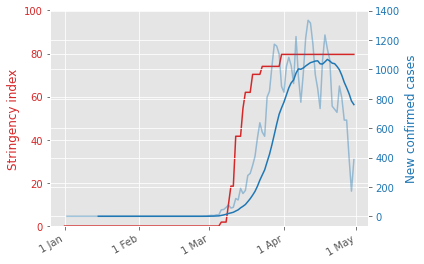

In [0]:
# Stringency index and new confirmed cases

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Stringency index', color=color)
ax1.plot(netherlands_measures['Date'], netherlands_measures['StringencyIndexForDisplay'], color=color)
ax1.set_ylim([0, 100])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New confirmed cases', color=color)  # we already handled the x-label with ax1
ax2.plot(netherlands_measures['Date'], netherlands_measures['NewCases'], color=color, alpha = 0.4)
ax2.plot(netherlands_measures['Date'], netherlands_measures['NewCases'].rolling(14).mean(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.xaxis.set_major_formatter(my_format)
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_minor_locator(months)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.autofmt_xdate() # format date

plt.show()

The rise in the stringency index precedes the increase in new confirmed cases. Indeed, the strigency of government reached its maximum at the very end of March. However, it took a few more weeks for new cases to peak.
This confirms the scientific evidence that there is a lag between the implementation of the measures and their benefits. 


### 2.1.5. Stringency phases and categories

We create categorical variables from the continuous stringency index, in order to perform our analysis. 

We have tried using Jenks's natural breaks classification method (with stringency only) and k-means clustering (with two dimensions: stringency and time), but with no conclusive results.

As a consequence, we did the classification manually. We use a subjective case-by-case approach in determining in which phase a given country is in. We choose numbers of phases depending on the country, starting with Phase 0 for no coronavirus measures.

In the next cell, we import the OxCGRT data available on the 4th May 2020 and perform the categorisation.

In [0]:
## From stringency (as a continuous variable) to phases (as categorical variable)

# Import Oxford data from 4th May

path = "drive/My Drive/Data/"

df = pd.read_csv(path + "OxCGRT_May.csv")

df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df = df[df['Date'] < '2020-05-01'] # Limit to 1st May - excluded

df = df[df['CountryName'].isin(country_list)]
stringency = df.pivot(index='Date', columns='CountryName', values='StringencyIndexForDisplay')
stringency = stringency[country_list]

# Define the phases based on data

phases = stringency.copy(deep = True)

# UK

phases.loc['2020-01-01':'2020-02-01', 'United Kingdom'] = 0
phases.loc['2020-02-02':'2020-03-15', 'United Kingdom'] = 1
phases.loc['2020-03-16':'2020-03-25', 'United Kingdom'] = 2
phases.loc['2020-03-26':'2020-04-30', 'United Kingdom'] = 3

# Canada

phases.loc['2020-01-01':'2020-03-10', 'Canada'] = 0
phases.loc['2020-03-11':'2020-03-19', 'Canada'] = 2
phases.loc['2020-03-20':'2020-04-25', 'Canada'] = 3
phases.loc['2020-04-26':'2020-04-30', 'Canada'] = 4

# Belgium

phases.loc['2020-01-01':'2020-01-27', 'Belgium'] = 0
phases.loc['2020-01-28':'2020-03-03', 'Belgium'] = 1
phases.loc['2020-03-04':'2020-03-19', 'Belgium'] = 2
phases.loc['2020-03-20':'2020-04-26', 'Belgium'] = 3
phases.loc['2020-04-27':'2020-04-30', 'Belgium'] = 4

# Netherlands

phases.loc['2020-01-01':'2020-03-05', 'Netherlands'] = 0
phases.loc['2020-03-06':'2020-03-30', 'Netherlands'] = 2
phases.loc['2020-03-31':'2020-04-30', 'Netherlands'] = 3

# Switzerland

phases.loc['2020-01-01':'2020-02-24', 'Switzerland'] = 0
phases.loc['2020-02-25':'2020-03-16', 'Switzerland'] = 2
phases.loc['2020-03-17':'2020-04-25', 'Switzerland'] = 3
phases.loc['2020-04-26':'2020-04-30', 'Switzerland'] = 4

# Sweden

phases.loc['2020-01-01':'2020-03-08', 'Sweden'] = 0
phases.loc['2020-03-09':'2020-04-03', 'Sweden'] = 2
phases.loc['2020-04-04':'2020-04-30', 'Sweden'] = 3

# Spain

phases.loc['2020-01-01':'2020-01-30', 'Spain'] = 0
phases.loc['2020-01-31':'2020-03-08', 'Spain'] = 1
phases.loc['2020-03-09':'2020-03-29', 'Spain'] = 2
phases.loc['2020-03-30':'2020-04-30', 'Spain'] = 3

# Italy

phases.loc['2020-01-01':'2020-01-29', 'Italy'] = 0
phases.loc['2020-01-30':'2020-02-20', 'Italy'] = 1
phases.loc['2020-02-21':'2020-03-10', 'Italy'] = 2
phases.loc['2020-03-11':'2020-04-30', 'Italy'] = 3

# Germany

phases.loc['2020-01-01':'2020-01-26', 'Germany'] = 0
phases.loc['2020-01-27':'2020-02-25', 'Germany'] = 1
phases.loc['2020-02-26':'2020-03-21', 'Germany'] = 2
phases.loc['2020-03-22':'2020-04-30', 'Germany'] = 3

# France

phases.loc['2020-01-01':'2020-01-22', 'France'] = 0
phases.loc['2020-01-23':'2020-02-24', 'France'] = 1
phases.loc['2020-02-25':'2020-03-16', 'France'] = 2
phases.loc['2020-03-17':'2020-04-30', 'France'] = 3

# Ireland 

phases.loc['2020-01-01':'2020-02-03', 'Ireland'] = 0
phases.loc['2020-02-04':'2020-03-11', 'Ireland'] = 1
phases.loc['2020-03-12':'2020-03-27', 'Ireland'] = 2
phases.loc['2020-03-28':'2020-04-30', 'Ireland'] = 3

In the next two cells, we create subplots of stringency for each country in our data set, using different colours to represent different phases.

In [0]:
## Prepare plot of stringency

# Create a phase-to-label dictionary for plotting

phase_to_label = {
    0: "No measures",
    1: "Few measures",
    2: "Stringency increasing",
    3: "Maximum stringency",
    4: "Lowering of measures"
}

# Create a phase-to-colour dictionary for plotting

phase_to_colour = {
    0: 'green',
    1: 'orange',
    2: 'red',
    3: 'purple',
    4: 'blue'
}

print("Complete.")

Complete.


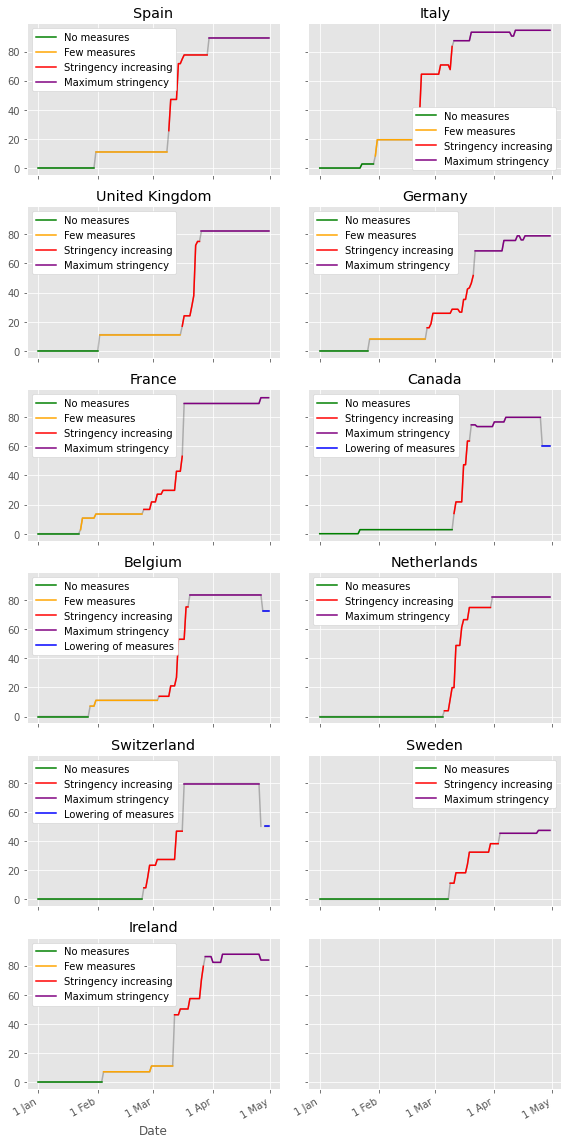

In [0]:
## Plot stringency with different colours for different phases

fig, axs = plt.subplots(6, 2, 
                        sharex = True,
                        sharey = True,
                        figsize = (8, 16))

index = 0

for country in country_list:

  row, col = divmod(index, 2)
  ax = axs[row, col]

  merged = pd.DataFrame({'stringency': stringency[country], 'phase': phases[country]})

  ax.plot(merged['stringency'], 'k', alpha = 0.25)
  grouped = merged.groupby('phase')

  for key, group in grouped:
    group.plot(ax = ax, 
              y = 'stringency', 
              label = phase_to_label[key],
              color = phase_to_colour[key])
    
  ax.set_title(country)
  ax.xaxis.set_major_formatter(my_format)
  ax.xaxis.set_major_locator(months)
  ax.xaxis.set_minor_locator(months)

  index = index + 1

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

We observe that in most countries, the intensity of stringency increases over time. The slope of the increase is rather sudden and happens within a short period of time. 
In Switzerland, Canada, and Belgium the government had started to lower the measures taken in the last few days of April.

## 2.2. Reddit data set: submissions and comments

<center>

![Reddit logo](https://upload.wikimedia.org/wikipedia/en/thumb/5/58/Reddit_logo_new.svg/320px-Reddit_logo_new.svg.png)

Source: [Wikipedia](https://en.wikipedia.org/wiki/File:Reddit_logo_new.svg)

</center>

The second data set is based on submissions from [Reddit](http://reddit.com/). According to [Wikipedia](https://en.wikipedia.org/wiki/Reddit), Reddit is a "social news aggregation, web content rating, and discussion website", and it is the 19th most visited website in the United States and in the world.

This subsection first details the data collection process. Then, we explain our data cleaning and text pre-processing procedures. We conclude by showing some word clouds for the [r/unitedkingdom](https://www.reddit.com/r/unitedkingdom/) subreddit.


### 2.2.1. Data collection

We focus on 11 country-specific subreddits (such as [r/netherlands](https://www.reddit.com/r/thenetherlands/)), and retrieve all submissions made between 1st January 2019 and 30th April 2020 using the [PSAW wrapper](https://psaw.readthedocs.io/) for the [Pushshift API](https://pushshift.io/). 

#### 2.2.1.1. Collecting Reddit submissions

The following cell defines the function to get submissions for a specific subreddit (`country` argument), for the time period between `first_day` and `last_day`, and create a csv file called `csv_name` if specified (otherwise, the file has the name of the country subreddit by default).

In [0]:
## Get submissions - Define function

api = PushshiftAPI()

# Define default time period 

first_day = datetime(2019, 1, 1) # Included
last_day = datetime(2020, 5, 1) # Excluded

# Define function

def get_submissions(country, first_day = first_day, last_day = last_day, csv_name = None):

  print("Getting submissions for r/" + country + "...")

  day_range = (last_day - first_day).days

  first_day = int(first_day.timestamp())
  each_day = 86400

  list_of_dataframes = []

  for i in range(day_range):

    stdout.write("\r%d" % (i+1) + "/" + str(day_range)) # Printing numbers at the beginning
    stdout.flush()

    start_epoch = first_day + i * each_day
    end_epoch = first_day + (1 + i) * each_day

    gen = api.search_submissions(after = start_epoch,
                                before = end_epoch, 
                                subreddit = country,
                                filter = ['id', 'created_utc', 'url', 'author', 'title', 'selftext', 'num_comments', 'pinned', 'score', 'stickied'],
                                limit = 999)

    list_of_dataframes.append(pd.DataFrame([thing.d_ for thing in gen]))

    sleep(1) # Max 1 request per second

  stdout.write("\n") # Goes with the printing numbers

  df = pd.concat(list_of_dataframes)
  df['created_time'] = pd.to_datetime(df['created_utc'], unit='s')
  df['created_date'] = df['created_time'].dt.date

  if csv_name is None:
    csv_name = country

  df.to_csv(directory + "Data/Reddit/" + csv_name + ".csv",
            index_label = "index_num")  
  print("Complete.")
  
  return(df)

print("Complete.")

Complete.


The next cell calls the newly created function and creates a new data frame for each country. 

Note that this operation takes many hours, which is why we do not run the code in this notebook. Instead, we have run this code once and saved the results in csv files, which we then use later in the analysis. 

If you do wish to run the code, please change the `if` condition to `True`. Alternatively, you can assign `True` to the `toggle_off` variable, to run the code in its entirety. 

In [0]:
## Get submissions - Call function

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  ## Full data - Get submissions for selected countries

  start_time = time() # Time it

  # United Kingdom 
  uk = get_submissions('unitedkingdom', csv_name = 'uk')

  # France 
  france = get_submissions('france', csv_name = 'france')

  # Germany
  germany = get_submissions('germany', csv_name = 'germany')

  # Spain
  spain = get_submissions('spain', csv_name = 'spain')

  # Italy
  italy = get_submissions('italy', csv_name = 'italy')

  # Switzerland
  switzerland = get_submissions('switzerland', csv_name = 'switzerland')

  # Belgium
  belgium = get_submissions('belgium', csv_name = 'belgium')

  # Canada
  canada = get_submissions('canada', csv_name = 'canada')

  # Netherlands
  netherlands = get_submissions('netherlands', csv_name = 'netherlands')

  # Ireland
  ireland = get_submissions('ireland', csv_name = 'ireland')

  # Sweden
  sweden = get_submissions('sweden', csv_name = 'sweden')

  # Print total run time
  total_time = round(time() - start_time)
  m, s = divmod(total_time, 60)
  h, m = divmod(m, 60)
  print(f'Total run time: {h} hours, {m:02d} minutes and {s:02d} seconds') 

To run the content of this cell, please change the if condition to True.


In the following cell, we import the data sets previously created and stored as csv files. 

We store the dataframes in a dictionary called `raw_submissions`, with keys corresponding to the country name. We do so to make it easier to loop through the different dataframes later in the analysis.

In [0]:
## Import data sets - Submissions

path = directory + 'Data/Reddit/'

files = [f for f in os.listdir(path) if isfile(join(path, f))]
print(files)

countries = [os.path.splitext(file)[0] for file in files]
print(countries)

raw_submissions = {} # Dataframes are stored in a dictionary, with the key being the country

for i in range(len(countries)): 
  raw_submissions[countries[i]] = pd.read_csv(path + files[i])
  raw_submissions[countries[i]]['country'] = countries[i]
  raw_submissions[countries[i]]['created_date'] = pd.to_datetime(raw_submissions[countries[i]]['created_date'])
  raw_submissions[countries[i]]['created_time'] = pd.to_datetime(raw_submissions[countries[i]]['created_time'])

print("Complete.")

['uk.csv', 'france.csv', 'germany.csv', 'spain.csv', 'italy.csv', 'switzerland.csv', 'belgium.csv', 'canada.csv', 'netherlands.csv', 'ireland.csv', 'sweden.csv']
['uk', 'france', 'germany', 'spain', 'italy', 'switzerland', 'belgium', 'canada', 'netherlands', 'ireland', 'sweden']
Complete.


Finally, we show what the dataframe for the Netherlands looks like.

In [0]:
# Example of submission data set: Netherlands

raw_submissions['netherlands'].tail(3)

,index_num,author,created_utc,id,num_comments,pinned,score,selftext,stickied,title,url,created,created_time,created_date,country
6189,21,Arietta39,1588228088,gaqg83,1,False,1,Hi! So I'm deciding which language to learn in...,False,Questions about Musical Theatre in The Netherl...,https://www.reddit.com/r/Netherlands/comments/...,1.588228e+09,2020-04-30 06:28:08,2020-04-30,netherlands
6190,22,TjSR1989,1588209683,gam773,7,False,1,NaN,False,Extreem-rechts gedachtegoed onder jongeren FvD...,https://www.volkskrant.nl/nieuws-achtergrond/e...,1.588210e+09,2020-04-30 01:21:23,2020-04-30,netherlands
6191,23,NastyF,1588205436,gal299,13,False,1,"Hello! I live in Madrid, Spain (I have tested ...",False,Help! Need to go to Amsterdam.,https://www.reddit.com/r/Netherlands/comments/...,1.588205e+09,2020-04-30 00:10:36,2020-04-30,netherlands


Variables of interest are:
* `title`: the title of the submission
* `id`: the id of the submission, which can be used to retrieve it on the website
* `selftext`: the text in the body of the submission
* `created_utc`: the time at which the submission was posted, in timestamp format, UTC time. Based on this variable, we create `created_time` and `created_date` which we use for our analysis

#### 2.2.1.2. Collecting Reddit comments

Some subreddits also have a "coronavirus megathread", in which all dicussions directly related to coronavirus take place. For these subreddits, we retrieve all comments made on these megathreads before 30th April.

The following cell defines the function to collect comments from these megathreads, based on the name of the subreddit (`country`), the `query` that should be passed to find these megathreads or the `list_id` of the megathreads. It returns a dataframe and saves a csv called `csv_name` (or `country` by default).

In [0]:
## Get comments from megathreads - Define function

# Define time period

covid_first_day = datetime(2020, 1, 1) # Start on 01/01/2020
covid_last_day = datetime(2020, 4, 30) # Included 30/04/2020

# Define function

def get_comments(country, query = None, list_id = None, csv_name = None):

  print("Getting comments for r/" + country + "...")
  
  if csv_name is None:
    csv_name = country

  # Get submissions with the query

  if query is not None: 

    gen = api.search_submissions(after = covid_first_day,
                                before = covid_last_day, 
                                subreddit = country,
                                q = query,
                                filter = ['id', 'created_utc', 'url', 'author', 'title', 'selftext', 'num_comments', 'pinned', 'score', 'stickied'])
    
    df = pd.DataFrame([thing.d_ for thing in gen])
    df['created_time'] = pd.to_datetime(df['created_utc'], unit='s')
    df['created_date'] = df['created_time'].dt.date

    df.to_csv(directory + "Data/Reddit/Comments/" + csv_name + "_list.csv",
              index_label = "index_num")

    submission_id = df['id']

  if list_id is not None:
    submission_id = list_id

  # Get comments for each submission

  list_of_dataframes = []

  for i in range(len(submission_id)):

    stdout.write("\r%d" % (i+1) + "/" + str(len(submission_id))) # Printing numbers at the beginning
    stdout.flush()

    gen = api.search_comments(link_id = submission_id[i],
                              filter = ['author', 'body', 'id', 'is_submitter', 'permalink', 'score', 'stickied', 'subreddit', 'created_utc'])
    
    max_response_cache = 1000
    cache = []

    for c in gen:
        cache.append(c)

    if False: # Pick up where we left off to get the rest of the results
        for c in gen:
            cache.append(c)

    comments = pd.DataFrame([thing.d_ for thing in list(cache)])
    comments['submission_id'] = submission_id[i]

    list_of_dataframes.append(comments)

    sleep(1) # Max 1 request per second

  stdout.write("\n") # Goes with the printing numbers

  # Create data frame for comments

  df = pd.concat(list_of_dataframes)
  df['created_time'] = pd.to_datetime(df['created_utc'], unit='s')
  df['created_date'] = df['created_time'].dt.date

  df.to_csv(directory + "Data/Reddit/Comments/" + csv_name + "_comments.csv",
            index_label = "index_num")
  print("Complete.")
  
  return(df)

print("Complete.")

Complete.


The next cell calls the `get_comments` function we just defined for different countries. Please note again that we do not run this code in this notebook, as this would take a couple of hours.

In [0]:
## Get comments - Call function

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  ## Full data - Get comments for megathreads for selected countries

  start_time = time() # Time it

  # UK 
  uk_comments = get_comments(country = 'unitedkingdom', 
                            query = 'Daily Discussion for Coronavirus (COVID-19)',
                            csv_name = 'uk')

  # France
  # No megathread

  # Germany 
  germany_comments = get_comments(country = 'germany',
                                  list_id = ['fd22xy'])

  # Spain
  # No megathread

  # Italy
  italy_comments = get_comments(country = 'italy',
                                  query = 'Megathread coronavirus')

  # Switzerland
  switzerland_megathreads = ['f9dinw', 'fgkiy3', 'fi291h', 'fkk39n', 'flqc2u', 'fqpois', 'g57v1s']
  switzerland_comments = get_comments(country = 'switzerland',
                                      list_id = switzerland_megathreads)

  # Belgium
  belgium_megathreads = ['fbrv96', 'fd1e56', 'fgagd3', 'fhl2ef', 'fk1557', 'fnfyzh', 'fu30rh', 'g39sjp']
  belgium_comments = get_comments(country = 'belgium', 
                                  list_id = belgium_megathreads)

  # Canada
  canada_megathreads = ['fjop94', 'fme6we']
  canada_comments = get_comments(country = 'canada',
                                list_id = canada_megathreads)

  # Netherlands
  # No megathread

  # Ireland
  ireland_comments_part_1 = get_comments(country = 'ireland',
                                        query = 'panic megathread',
                                        csv_name = 'ireland_part_1')
  ireland_comments_part_2 = get_comments(country = 'ireland',
                                        query = 'covid-19 megathread',
                                        csv_name = 'ireland_part_2')
  ireland_comments = ireland_comments_part_1.append(ireland_comments_part_2)
  ireland_comments.to_csv(directory + "Data/Reddit/Comments/ireland_comments.csv",
                          index_label = "index_num")

  # Sweden
  sweden_comments = get_comments(country = 'sweden',
                                query = 'Megatråd - Coronavirus')
  
  # Print total run time
  total_time = round(time() - start_time)
  m, s = divmod(total_time, 60)
  h, m = divmod(m, 60)
  print(f'Total run time: {h} hours, {m:02d} minutes and {s:02d} seconds') 

To run the content of this cell, please change the if condition to True.


We import the comment data sets that were previously created in the next cell. As for the submissions, we store the dataframes in a dictionary called `raw_comments`, with the name of the countries as keys.

In [0]:
## Import data sets - Comments 

path = directory + 'Data/Reddit/Comments/'

all_files = [f for f in os.listdir(path) if isfile(join(path, f))]
print(all_files)

comments_files = [file for file in all_files if file.endswith("comments.csv")]
print(comments_files)

comments_countries_full = [os.path.splitext(file)[0] for file in comments_files]
comments_countries_full.remove('ireland_part_1_comments')
comments_countries_full.remove('ireland_part_2_comments')
print(comments_countries_full)

comments_countries = [string.split('_')[0] for string in comments_countries_full]
print(comments_countries)

raw_comments = {}

for i in range(len(comments_countries)): 
  raw_comments[comments_countries[i]] = pd.read_csv(path + comments_countries[i] + "_comments.csv", engine='python')
  raw_comments[comments_countries[i]]['country'] = comments_countries[i]
  raw_comments[comments_countries[i]]['created_date'] = pd.to_datetime(raw_comments[comments_countries[i]]['created_date'])
  raw_comments[comments_countries[i]]['created_time'] = pd.to_datetime(raw_comments[comments_countries[i]]['created_time'])

del(comments_files, all_files, comments_countries_full)

print("Complete.")

['uk_list.gsheet', 'italy_list.gsheet', 'uk_list.csv', 'uk_comments.csv', 'germany_comments.csv', 'italy_list.csv', 'italy_comments.csv', 'switzerland_comments.csv', 'belgium_comments.csv', 'canada_comments.csv', 'ireland_part_1_list.csv', 'ireland_part_1_comments.csv', 'ireland_part_2_list.csv', 'ireland_part_2_comments.csv', 'ireland_comments.csv', 'sweden_list.csv', 'sweden_comments.csv']
['uk_comments.csv', 'germany_comments.csv', 'italy_comments.csv', 'switzerland_comments.csv', 'belgium_comments.csv', 'canada_comments.csv', 'ireland_part_1_comments.csv', 'ireland_part_2_comments.csv', 'ireland_comments.csv', 'sweden_comments.csv']
['uk_comments', 'germany_comments', 'italy_comments', 'switzerland_comments', 'belgium_comments', 'canada_comments', 'ireland_comments', 'sweden_comments']
['uk', 'germany', 'italy', 'switzerland', 'belgium', 'canada', 'ireland', 'sweden']
Complete.


Finally, we show an example of the comments data set for the United Kingdom.

In [0]:
# Example of comments data set: UK

raw_comments['uk'].head(3)

,index_num,author,body,created_utc,id,is_submitter,permalink,score,stickied,subreddit,created,submission_id,created_time,created_date,country
0,0,360Saturn,"No, I mean just normal folk. Maybe it had take...",1588250153,fp1x1x8,False,/r/unitedkingdom/comments/g9yvze/daily_discuss...,1,False,unitedkingdom,1.588250e+09,g9yvze,2020-04-30 12:35:53,2020-04-30,uk
1,1,wiktorpolak,Silver spoons like you are the ones that keep ...,1588234361,fp1g447,False,/r/unitedkingdom/comments/g9yvze/daily_discuss...,1,False,unitedkingdom,1.588234e+09,g9yvze,2020-04-30 08:12:41,2020-04-30,uk
2,2,SimplySkedastic,How is any of this related to mask wearing whi...,1588234102,fp1fugc,False,/r/unitedkingdom/comments/g9yvze/daily_discuss...,1,False,unitedkingdom,1.588234e+09,g9yvze,2020-04-30 08:08:22,2020-04-30,uk


Variables of interest are:
* `body`: the body of the comment
* `created_date`: the date when the comment was written/generated based on `created_utc` (as for the submission data)

### 2.2.2. Data cleaning

In this subsection, we describe our data cleaning process.

The first cell creates a function to clean the submission data, and call it on each dataframe in the `raw_submissions` dictionary. We remove submissions with no text in the main body, or with "[removed]" or "[deleted]". We also create a `full_text` column, which contains both the title and the main body of the submission.
We store the results in a new dictionary called `submissions`. 


In [0]:
# Clean submisions

def submission_cleaning(df):

  # Drop NA
  df = df.dropna(subset = ['selftext'])

  # Remove submissions with [removed] or [deleted]
  df = df[df['selftext'] != "[removed]"]
  df = df[df['selftext'] != "[deleted]"]

  # Create a full text column
  df['full_text'] = df['title'] + " " + df['selftext'] 

  # Reset index
  df.reset_index(inplace = True, drop = True)

  # Return
  return(df)

submissions = {}

for country in countries:
   submissions[country] = submission_cleaning(raw_submissions[country])

print("Complete.")

Complete.


The next cell implements a similar procedure for comments. We define the function to clean comments, call it on all the dataframes in the `raw_comments` dictionary, and obtain a clean `comments` dictionary.

In [0]:
# Clean comments

def comments_cleaning(df): 

  # Drop NA
  df = df.dropna(subset = ['body'])

  # Remove comments with [removed] or [deleted]
  df = df[df['body'] != "[removed]"]
  df = df[df['body'] != "[deleted]"]

  # Create a full text column - same name as submissions, to make it easier for loops
  df['full_text'] = df['body'] 

  # Reset index
  df.reset_index(inplace = True, drop = True)

  # Return
  return(df)

comments = {}

for c in comments_countries:
  comments[c] = comments_cleaning(raw_comments[c])

print("Complete.")

Complete.


### 2.2.3. Text pre-processing

This part presents our text pre-processing steps for the Reddit data. We first define functions, that we call together in a final cell.

The first cell implements tokenisation, which turns text into word tokens. We lowercase the tokens, and remove the punctuation, repeated letters, and special characters.


In [0]:
## Tokenisation

special_char = ['gt', 'amp', 'x200b', 'https', 'http', 'www', 'co', 'uk'] # Define special characters to remove

def clean_tokens(text_column):

  raw_tokens = [word_tokenize(content) for content in text_column] # List of lists

  tokens = []

  for sublist in raw_tokens: # Clean tokens
    clean_sublist = []
    for word in sublist:
      if word.isalnum(): # Remove punctuation
        word = word.lower() # Lowercase
        word = re.sub(r'(.)\1\1+', r'\1', word) # Remove repeated letters e.g. Fridaaay ==> Friday, but Fridaay ==> Fridaay
        if word not in special_char: # Remove special characters
          clean_sublist.append(word) 
    tokens.append(clean_sublist)

  return(pd.Series(tokens)) # Return series (with list for each observation)

print("Complete.")

Complete.


Next, we detect the language of each submission or comment, using the `detect` function from the `langdetect` package.

In [0]:
## Detect language

def find_language(text_column):

  languages = []

  for row in range(len(text_column)):
    try:
      languages.append(detect(text_column.iloc[row]))
    except: 
      languages.append("")

  return(pd.Series(languages)) # Return series (with list for each observation)

print("Complete.")

Complete.


We then remove the stopwords based on the language detected above, using the stopwords list from the `nltk` package.

In [0]:
## Remove stop words (based on language)

# Define a dictionary for the languages

stopwords_dict = {
    'en': stopwords.words('english'),
    'fr': stopwords.words('french'),
    'de': stopwords.words('german'),
    'es': stopwords.words('spanish'),
    'it': stopwords.words('italian'),
    'nl': stopwords.words('dutch'), 
    'sv': stopwords.words('swedish')
}

lang_list = stopwords_dict.keys()

# Remove stopwords

def remove_stopwords(token_col, language_col):

  no_stops = []

  for row in range(len(token_col)):

    if language_col.iloc[row] in lang_list:
      no_stops_row = [t for t in token_col.iloc[row] if t not in stopwords_dict[language_col.iloc[row]]]
      no_stops.append(no_stops_row)

    else: 
      no_stops.append("")

  return(pd.Series(no_stops))

print("Complete.")

Complete.


The next step is stemming, which shortens words to their roots. Without stemming, different words from the same family (such as "happy" and "happiness", or "cars" and "car") will be counted as different tokens. 

We create a `stemmer` dictionary using the Snowball stemmer from the `nltk` package, for the different languages in our data set. We then show an example of how the stemmer works.

In [0]:
## Define a dictionary for stemmer

stemmer = {
    'en': SnowballStemmer('english'),
    'fr': SnowballStemmer('french'),
    'de': SnowballStemmer('german'),
    'es': SnowballStemmer('spanish'),
    'it': SnowballStemmer('italian'),
    'nl': SnowballStemmer('dutch'), 
    'sv': SnowballStemmer('swedish')
}

# Example

print("happy ->", stemmer['en'].stem("happy"))
print("happiness ->", stemmer['en'].stem("happiness"))

print("car ->", stemmer['en'].stem("car"))
print("cars ->", stemmer['en'].stem("cars"))

happy -> happi
happiness -> happi
car -> car
cars -> car


Next, we create a function to stem the tokens based on the language detected.

In [0]:
## Stem (based on language)

# Stem based on language

def stem_tokens(no_stops, language_col):

  stemmed = [] 
  stemmed_join = []

  for row in range(len(no_stops)):

    if language_col.iloc[row] in lang_list:

      lang = language_col.iloc[row]
      
      stemmed_row = [stemmer[lang].stem(t) for t in no_stops.iloc[row]] # Return a list
      stemmed.append(stemmed_row)

      join_row = " ".join(t for t in stemmed_row) # Return a string
      stemmed_join.append(join_row)

    else: 
      stemmed.append("")
      stemmed_join.append("")

  return(pd.Series(stemmed), pd.Series(stemmed_join))

print("Complete.")

Complete.


Finally, we call the functions we have defined above. The cell takes about 45 minutes to run, which is why we do not run it in this notebook. 
Instead, we run it only once and save the pre-processed data in a separate file to be retrieved later.

In [0]:
## Pre-processing data - Comments and submissions

print("To run the content of this cell, please change the if condition to True.")

if toggle_off: 

  start_time = time() # Time it

  # Create a reddit dictionary to make it easier to do the same thing on 
  # submissions and comments. 

  reddit = {
      'submissions': submissions, 
      'comments': comments
      }

  # reddit is a dictionary with submissions (as a dictionary of dataframes) 
  # and comments (as a dictionary of dataframes) as entries

  for doc_type in reddit.keys():

    for country in reddit[doc_type].keys(): 

      print("Pre-processing", doc_type, "from r/" + country + "...")
      df = reddit[doc_type][country]

      # Tokenize words and clean the tokens
      df['tokens'] = clean_tokens(df['full_text'])

      # Find language
      DetectorFactory.seed = 123 # To ensure reproduceable results
      df['language'] = find_language(df['full_text'])

      # Remove stop words based on language
      df['no_stops'] = remove_stopwords(df['tokens'], df['language'])

      # Stem based on language
      df['stemmed'], df['stemmed_join'] = stem_tokens(df['no_stops'], df['language'])

  # Save file
  path = directory + 'Data/Clean/'
  filename = path + 'reddit'
  outfile = open(filename, 'wb')
  pickle.dump(reddit, outfile)
  outfile.close()

  # Print total run time
  total_time = round(time() - start_time)
  m, s = divmod(total_time, 60)
  print(f'Total run time: {m} minutes and {s:02d} seconds') # 45 min 55 sec

To run the content of this cell, please change the if condition to True.


In the next cell, we retrieve the pre-processed data generated in the previous step.

Note that the data is now stored in a dictionary of dictionaries. First, the `reddit` dictionary contains two entries, `submissions` and `comments`. Each of this is a dictionary of its own, with entries corresponding to each country. We use this method to make it easier to do the same tasks on both submissions and comments using loops.

In [0]:
## Open pre-processed data

# Open data (produced by previous cell)

path = directory + 'Data/Clean/'
filename = path + 'reddit'

infile = open(filename,'rb')
reddit = pickle.load(infile)
infile.close()

# Delete submissions and comments
# Use the clean reddit['submissions'] and reddit['comments'] instead

del(submissions, comments, raw_submissions, raw_comments)

print("Complete.")

Complete.


### 2.2.4. Summary statistics and word clouds

This part presents some summary statistics for the Reddit data set.

First, we plot the evolution of submissions and comments over time. Then, we look at the distribution of languages used in our sample of subreddits. 
Finally, we present some word clouds to visualise the most important topics in a given subreddit.

#### 2.2.4.1. Evolution of submissions and comments over time

We first look at the evolution the number and sentiment of submissions and comments over time.

In the next cell, we describe a function to plot the submissions (and comments), which we call in the two subsequent cells.

In [0]:
## Descriptive statistics - Define function

# Number of submissions over time by country - 7 day moving average

def plot_submissions(country, row, col, roll_time = 1, comments_on = False):

  for year in [2019, 2020]:

    df = reddit["submissions"][country] 
    df = df[df['created_date'] < datetime(year, 5, 1)]
    df = df[df['created_date'] > datetime(year, 1, 1)]

    if year == 2019:
      df['date_new'] = [date + relativedelta(years = 1) for date in df['created_date']]
      year_color = "b"
    elif year == 2020:
      df['date_new'] = df['created_date']
      year_color = "g"

    subs = df.groupby('date_new').size()
    subs = subs.rolling(roll_time).mean()
    axs[row, col].plot(subs, year_color, label = "Submissions in " + str(year))

  if comments_on == True:
    if country in reddit["comments"].keys():
      df = reddit["comments"][country]
      comms = df.groupby('created_date').size()
      comms = comms.rolling(roll_time).mean()
      axs[row, col].plot(comms, "r", label = "Comments in megathread")
  
  axs[row, col].xaxis.set_major_formatter(my_format)
  axs[row, col].xaxis.set_major_locator(months)
  axs[row, col].xaxis.set_minor_locator(months)
  axs[row, col].legend()
  axs[row, col].set_title(capitalise_country[country])

print("Complete.")

Complete.


First, we plot the evolution of submissions over time, with the date on the x-axis and the number of submissions on the y-axis, with different colours for the years 2019 and 2020.

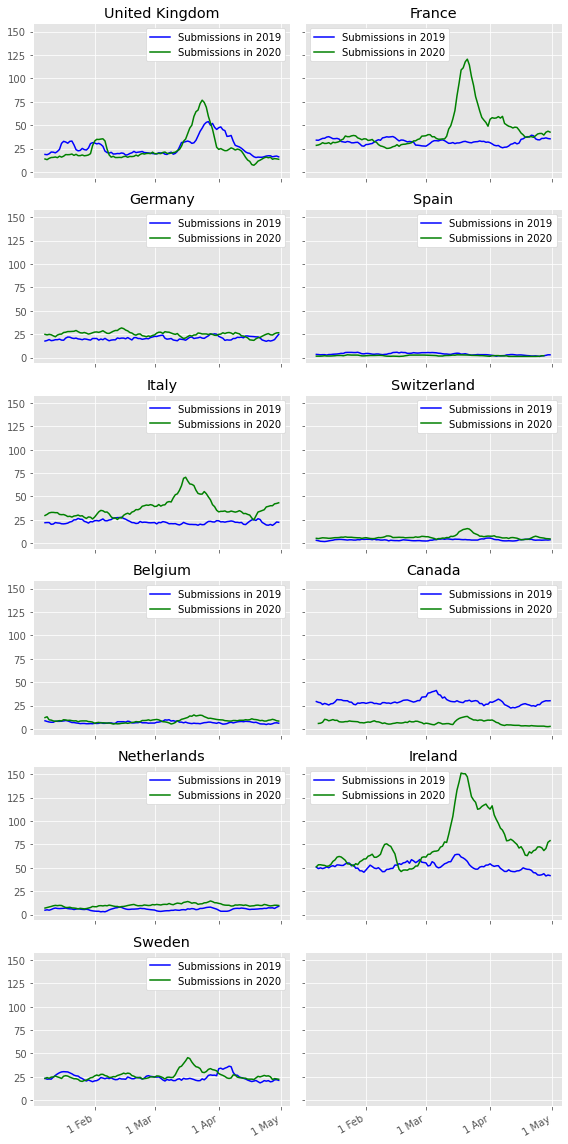

In [0]:
## Plot submissions - without comments_on = False

plt.style.use('ggplot')

fig, axs = plt.subplots(6, 2, 
                        sharex = True,
                        sharey = True,
                        figsize = (8, 16))

index = 0

for country in reddit["submissions"].keys():
  row, col = divmod(index, 2)
  plot_submissions(country, row, col, roll_time = 7, comments_on = False)
  index = index + 1

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

We observe that submissions were higher in March 2020 (at the start of the coronavirus crisis) than in March 2019, especially for the France, Italy and Ireland subreddits.

Next, we plot the submissions and the comments to the coronavirus megathreads. 

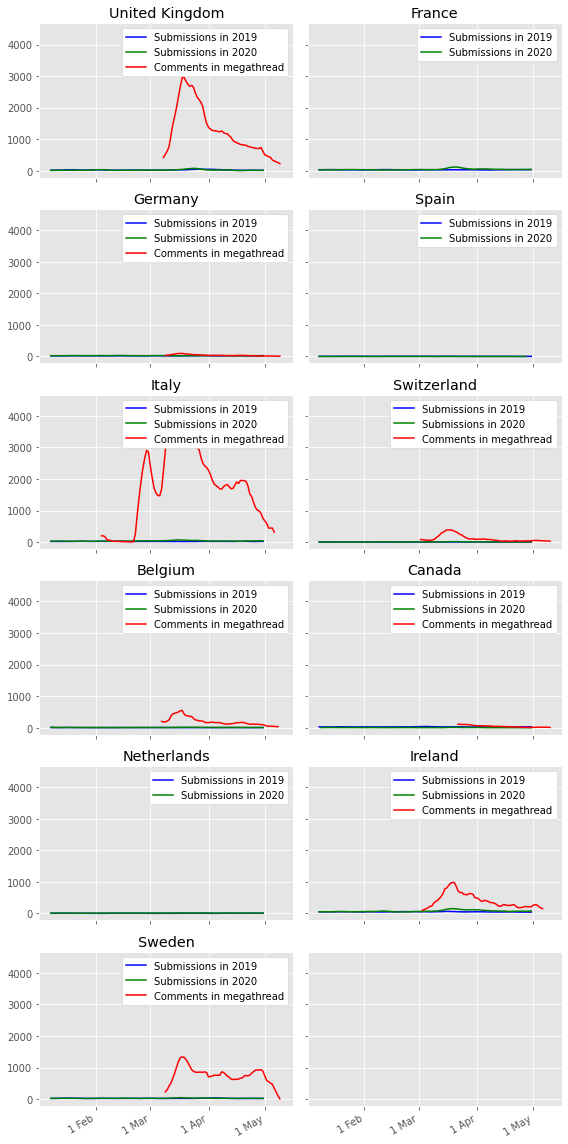

In [0]:
# Plot submissions - with comments_on = True

fig, axs = plt.subplots(6, 2, 
                        sharex = True,
                        sharey = True,
                        figsize = (8, 16))

index = 0

for country in reddit["submissions"].keys():
  row, col = divmod(index, 2)
  plot_submissions(country, row, col, roll_time = 7, comments_on = True)
  index = index + 1

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

We also plot the comments in the coronavirus megathreads for subreddits which have them. We see that these megathreads were especially active in March 2020 in the United Kingdom, Italy, Ireland and Sweden.
The scale used also shows that the number of comments is much higher than the number of submissions for these subreddits.

#### 2.2.4.2. Main languages on Reddit

In the next cell, we define and call a function to plot the main languages on each subreddit.

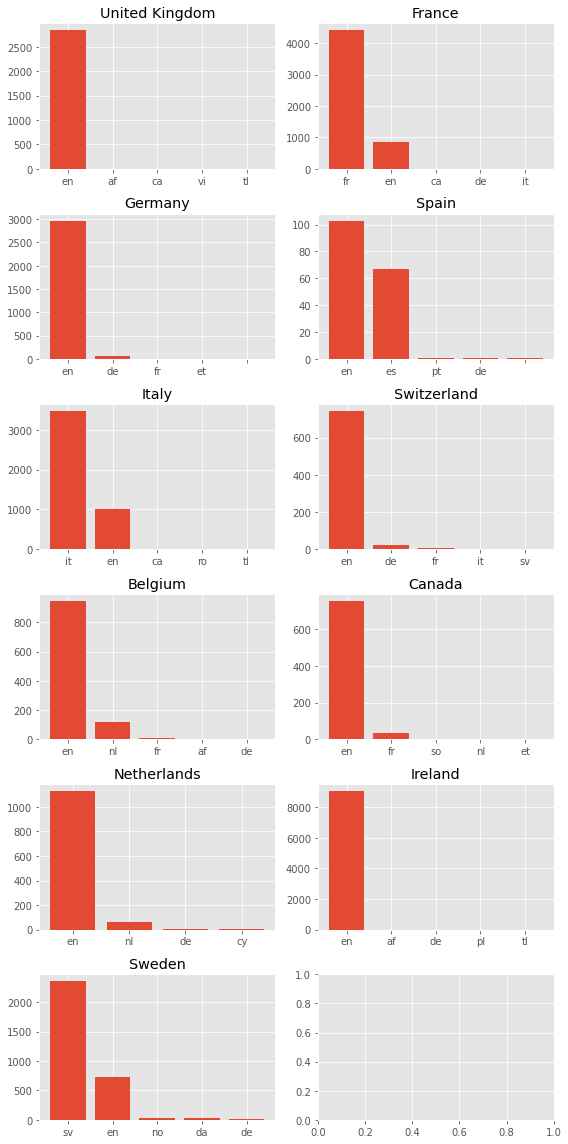

In [0]:
## Descriptive statistics - Languages

# Define function

def plot_languages(country, row, col):

  df = reddit['submissions'][country] 
  df = df[df['created_date'] < datetime(2020, 5, 1)]
  df = df[df['created_date'] > datetime(2020, 1, 1)]

  top_languages = df.groupby('language').size().sort_values(ascending=False).head()
  axs[row, col].bar(top_languages.index, top_languages)
  axs[row, col].set_title(capitalise_country[country])

# Plot

fig, axs = plt.subplots(6, 2, figsize = (8, 16))

index = 0

for country in reddit['submissions'].keys():
  row, col = divmod(index, 2)
  plot_languages(country, row, col)
  index = index + 1

plt.tight_layout()
plt.show()

We can see that English is the dominant language on Reddit, even for some countries where the first language is not English (such as the Netherlands, Belgium, and Spain). In the subreddits for France, Italy, and Sweden, the local language remains the main language used.

#### 2.2.4.3. Word clouds

Finally, we create some word clouds for each month starting in January 2020 for the United Kingdom.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


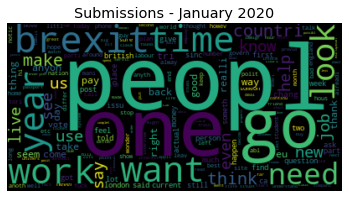

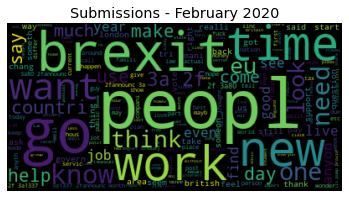

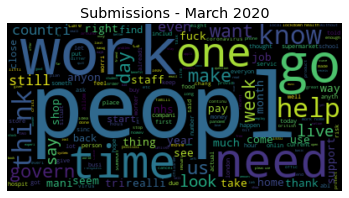

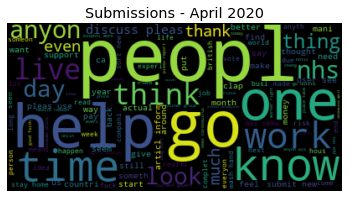

In [0]:
## Word cloud by month starting in January 2020 - for UK 

country = 'uk'

# Dictionary for months
dict_month = {
    1: "January 2020",
    2: "February 2020",
    3: "March 2020",
    4: "April 2020", 
    5: "May 2020"
}

# Get submissions
df = reddit["submissions"][country]
doc_type_label = "Submissions - "
start_month = 1
end_month = 4

# Subset submissions and create month column
df = df[df['created_date'] >= datetime(2020, 1, 1)]
df['month'] = df['created_date'].dt.month

for month in range(start_month, end_month + 1):
  temp = df[df['month'] == month]
  join_all = " ".join(text for text in temp["stemmed_join"])
  cloud = WordCloud().generate(join_all)
  plt.imshow(cloud, interpolation="bilinear")
  plt.title(doc_type_label + dict_month[month])
  plt.axis('off')
  plt.show()
  print("\n")

We can see that the most frequent stemmed tokens are "peopl", "time", "go" for example. 

Interestingly, "Brexit" is one of the main tokens for January and February 2020, before the start of the coronavirus crisis in Europe. However, "Brexit" does not appear in March and April 2020, showing that this is not a main topic anymore. 

Moreover, "NHS" (National Health Service) is also an important token in April 2020, which is consistent with a focus on the coronavirus crisis, as the NHS was very sollicited during this period.

# 3. Analysis and results

In this section, we present the main results from the analysis.

First, we look at the relationship between the sentiment of Reddit submissions and the stringency of government measures.

Secondly, we try to predict mentions of coronavirus using other words from submissions.

Finally, we attempt to predict the phase in which a country is based on Reddit submissions.

## 3.1. Sentiment of Reddit submissions and stringency of government measures

In this subsection, we answer our first research question: *Is the sentiment of Reddit submissions significantly different when government measures are stringent, compared to when they are not?*

To measure the sentiment of the submissions, we apply two lexicon-based methods: VADER and TextBlob.

The first tool we use is [TextBlob](https://textblob.readthedocs.io/en/dev/), which produces a polarity score ranging from -1 (negative) to +1 (positive). It also provides a subjectivity score ranging from 0 (very objective) to 1 (very subjective).

The second tool we use is [VADER](https://pypi.org/project/vader-sentiment/) (Valence Aware Dictionary and sEntiment Reasoner), which is an advanced sentiment analysis algorithm that is able to include sentiments from emoticons such as `:-)`, sentiment-related acronyms (e.g. "lol") and slang (e.g. "meh"). 

In the next cell, we demonstrate how these tools work, using an example of positive and negative text.

In [0]:
## Demonstrate VADER and TextBlob

positive_text = "Today is such a great day, I'm so happy!"
negative_text = "Today is not a good day, I'm so tired and grumpy..."


# VADER

print("VADER:\n")

analyser = SentimentIntensityAnalyzer() 

print("Positive text:")
print(analyser.polarity_scores(positive_text))

print("Negative text:")
print(analyser.polarity_scores(negative_text))

# TextBlob

print("\nTextblob:\n")

print("Positive text:")
print(TextBlob(positive_text).sentiment)

print("Negative text:")
print(TextBlob(negative_text).sentiment)

VADER:

Positive text:
{'neg': 0.0, 'neu': 0.434, 'pos': 0.566, 'compound': 0.8788}
Negative text:
{'neg': 0.406, 'neu': 0.594, 'pos': 0.0, 'compound': -0.7309}

Textblob:

Positive text:
Sentiment(polarity=0.6, subjectivity=0.75)
Negative text:
Sentiment(polarity=-0.375, subjectivity=0.65)


VADER returns a positive, negative, neutral scores, which add up to 1. It also returns a compound score, which is a standardised score between -1 (extremely negative) and +1 (extremely positive). We focus on the compound score for the rest of the analysis.

The sentiment method of the TextBlob object returns two metrics: polarity and subjectivity. Polarity is similar to the compound score in VADER. It is a float ranging between -1 (extremely negative) and +1 (extremely positive). Subjectivity refers to how subjective a sentence is, which goes from 0 (most objective) to 1 (most subjective). 

For the positive sentence, VADER's compound score is 0.88, whereas TextBlob's polarity score is 0.60. Both numbers are positive, as expected.

For the negative sentence, VADER's compound score is -0.73. The TextBlob's polarity score is -0.38. Both numbers are negative, as expected.

Note that in both cases, the VADER score is more extreme than the TextBlob score, suggesting that VADER might be more sensitive and more reliable than TextBlob.

In the next cell, we create a function to get the compound score from VADER and the polarity score from TextBlob for each observation in our dataframes. Note that we only keep submissions written in English, as VADER and TextBlob work only in English.

In [0]:
## VADER and TextBlob

analyser = SentimentIntensityAnalyzer() # For VADER

def get_polarity(reddit):

  for doc_type in reddit.keys(): 

    for country in reddit[doc_type].keys():

      print("Getting scores for", doc_type, "from r/" + country + "...")
      df = reddit[doc_type][country]

      # Only keep English text
      df = df[df['language'] == 'en'] # Will delete columns, not full data set

      # VADER
      vader_scores = [analyser.polarity_scores(text) for text in df['full_text']]
      vader_polarity = [vader_scores[row]['compound'] for row in range(len(vader_scores))]
      df['vader_polarity'] = vader_polarity

      # TextBlob
      tb_valence = [TextBlob(text) for text in df['full_text']]
      tb_sentiments = [blob.sentiment for blob in tb_valence]
      tb_polarity = [sentiment[0] for sentiment in tb_sentiments]
      df['tb_polarity'] = tb_polarity

      # Put back
      reddit[doc_type][country] = df

  return(reddit)

print("Complete.")

Complete.


In the next cell, we run the function and save the results in a separate file.

In [0]:
# Get polarity

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Time it
  start_time = time() 

  # Get polarity
  reddit_polarity = get_polarity(reddit)

  # Save
  path = directory + 'Data/Clean/'
  filename = path + 'reddit_polarity'
  outfile = open(filename, 'wb')
  pickle.dump(reddit_polarity, outfile)
  outfile.close()

  # Print total run time
  total_time = round(time() - start_time)
  m, s = divmod(total_time, 60)
  print(f'Total run time: {m} minutes and {s:02d} seconds') # 6 minutes 06 seconds

To run the content of this cell, please change the if condition to True.


We open the file created in the previous cell.

In [0]:
## Open data

path = directory + 'Data/Clean/'
filename = path + 'reddit_polarity'

infile = open(filename,'rb')
reddit_polarity = pickle.load(infile)
infile.close()

print("Complete.")

Complete.


We perform some summary statistics and look at the correlation between sentiment and the stringency of government measures. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


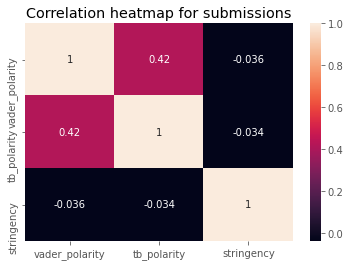



                        variables  corr coef  p-value
0  vader_polarity and tb_polarity      0.421      0.0
1   vader_polarity and stringency     -0.036      0.0
2      tb_polarity and stringency     -0.034      0.0




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


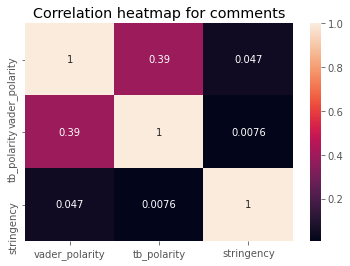



                        variables  corr coef  p-value
0  vader_polarity and tb_polarity      0.392    0.000
1   vader_polarity and stringency      0.047    0.000
2      tb_polarity and stringency      0.008    0.005




In [0]:
## Summary statistics and correlation with stringency

# Define function

def get_correlations(df, doc_type):

  # Keep only 2020
  df = df[df['created_date'] >= '2020-01-01']

  # Create variables for merge with government measures data set
  df['CountryName'] = df['country'].map(capitalise_country)
  df['Date'] = df['created_date']

  # Merge with government measures data
  df = df.merge(gov_measures, how = 'left', on = ['CountryName', 'Date'])

  # Plot correlation heatmap
  df['stringency'] = df['StringencyIndexForDisplay']
  df = df[['vader_polarity', 'tb_polarity', 'stringency']]
  corr = df.corr()
  sns.heatmap(corr, 
              xticklabels = corr.columns, 
              yticklabels = corr.columns, 
              annot = True)
  plt.title("Correlation heatmap for " + doc_type)
  plt.show()

  ## Dataframe with correlation coefficients and p-values

  corr_dict = {'variables': [], 'corr coef': [], 'p-value': [] }
  df = df.dropna()

  def get_corr(var1, var2):
    corr = pearsonr(df[var1], df[var2])
    corr_dict['variables'].append(var1 + ' and ' + var2)
    corr_dict['corr coef'].append(round(corr[0], 3))
    corr_dict['p-value'].append(round(corr[1], 3))

  get_corr('vader_polarity', 'tb_polarity')
  get_corr('vader_polarity', 'stringency')
  get_corr('tb_polarity', 'stringency')

  print("\n")
  print(pd.DataFrame(corr_dict))

# Run function

for doc_type in reddit_polarity:

  df_full = pd.DataFrame()

  for country in reddit_polarity[doc_type].keys():
    df = reddit_polarity[doc_type][country]
    df['country'] = country
    df_full = df_full.append(df)

  get_correlations(df_full, doc_type)
  print("\n")

We perform the analysis for both submissions and comments.

For submissions, the correlation between the VADER and TextBlob sentiment scores is 0.42, and statistically significant. As for comments, the correlation between the two sentiment scores is 0.39. This is relatively low, suggesting that these lexicon-based methods may not be very reliable.

Moreover, the correlation between stringency and the sentiment scores is very low in magnitude, even though statistically significant (given the given the relatively large sample size). The correlations are negative for submissions, but positive for comments.

We were surprised by these results, as we expected a significantly negative correlation between stringency and sentiment. 
Indeed, we expected that more stringent policy responses are associated with a more negative mood, as the social distancing measures might have a negative impact on people's mental health. 
However, the small magnitude of the coefficients seems to suggest that the stringency of the government measures did not have a strong direct impact on the sentiment of Reddit submissions.

In the next two cells, we define a function to plot the polarity scores by country over time, and call this function to create the graph.

In [0]:
## Plot polarity over time by country

# Define function

def plot_polarity(df, row, col, roll_time):

  tb_pol = df.groupby('created_date')['tb_polarity'].mean()
  axs[row, col].plot(tb_pol, "b", label = "TextBlob polarity", alpha = 0.4)

  tb_rolling = tb_pol.rolling(roll_time).mean()
  axs[row, col].plot(tb_rolling, "b", label = str(roll_time) + "-day moving average")

  vader_pol = df.groupby('created_date')['vader_polarity'].mean()
  axs[row, col].plot(vader_pol, "g", label = "VADER polarity", alpha = 0.4)

  vader_rolling = vader_pol.rolling(roll_time).mean()
  axs[row, col].plot(vader_rolling, "g", label = str(roll_time) + "-day moving average")

  axs[row, col].legend()
  axs[row, col].set_title(capitalise_country[country])

print("Complete.")

Complete.


[]

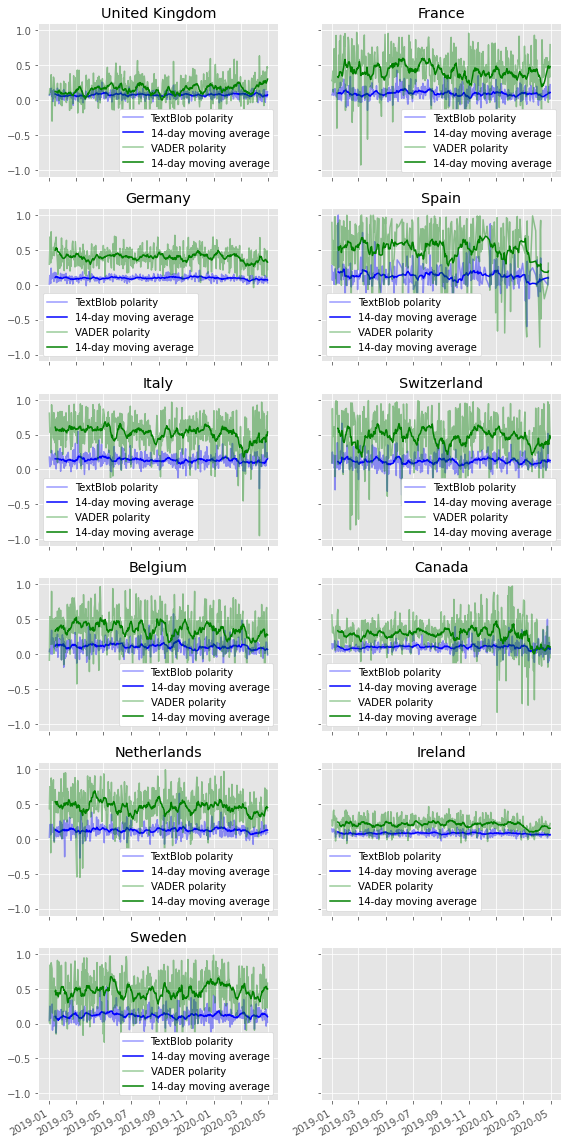

In [0]:
# Plot for submissions

fig, axs = plt.subplots(6, 2, 
                        sharex = True,
                        sharey = True,
                        figsize = (8, 16))

index = 0

for country in reddit_polarity['submissions'].keys():
  df = reddit_polarity['submissions'][country] 
  row, col = divmod(index, 2)
  plot_polarity(df, row, col, 14)
  index = index + 1

fig.autofmt_xdate()

plt.tight_layout()
plt.plot()

We plot the two polarity scores for each country seperately. 

We can see that these scores are mostly positive, and that the VADER scores are consistently more positive than the TextBlob scores, and display more variation. This is consistent with what we had found earlier in our example, which showed that VADER scores are more extreme than TextBlob scores. 

We cannot distinguish a clear trend for these scores over the one-and-a-half-year period. Again, this seems to confirm that the sentiment of Reddit submissions is unrelated with the coronavirus outbreak and the government measures resulting from it.

In the next cell, we do the same plot for comments in the coronavirus megathreads. 

[]

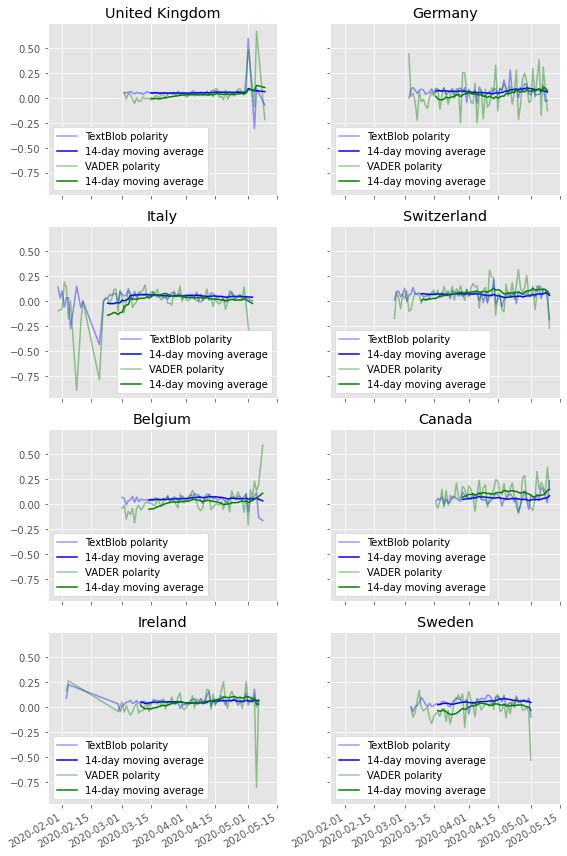

In [0]:
# Plot for comments

fig, axs = plt.subplots(4, 2, 
                        sharex = True,
                        sharey = True,
                        figsize = (8, 12))

index = 0

for country in reddit_polarity['comments'].keys():
  df = reddit_polarity['comments'][country] 
  row, col = divmod(index, 2)
  plot_polarity(df, row, col, 14)
  index = index + 1

fig.autofmt_xdate()

plt.tight_layout()
plt.plot()

The comments have both a TextBlob and VADER score close to zero for all countries in our sample, which is more negative than the submissions. 

Like for the comments, we cannot see a clear trend in the sentiment of these comments over time.

## 3.2. Predicting mentions of coronavirus using other words from submissions

In this subsection, we focus on our first prediction task, which acts as an introduction to the main task. We aim to answer our second research question: *Is it possible to predict whether a submission mentions coronavirus based on other words in the submission? Which words are associated with mentions of coronavirus?*

Our goal is to predict mentions of coronavirus using other words present in the same submission. We use a Naive Bayes classifier, which allows us to interpret the coefficients and see which words exactly are associated with mentions of coronavirus.

### 3.2.1. Posts mentioning coronavirus

First, we retrieve different names for  coronavirus from the [WHO website](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/technical-guidance/naming-the-coronavirus-disease-(covid-2019)-and-the-virus-that-causes-it) in order not to miss any mentions of the virus due to an alternative term. 

In the next cell, we add a new column to our dataframe with a dummy variable equal to 1 when coronavirus (or its alternative names) is mentioned, and 0 otherwise.

In [0]:
## Add a column for mentions of coronavirus / covid-19 / SARS-CoV-2 / etc.

coronavirus_names = ['coronavirus', 'covid', 'covid-19', 'covid19',
                     'sars-cov-2', 'sars', 'sarscov2', 
                     '2019-ncov', 'ncov', '2019ncov']

# Define the function 

def check_coronavirus(text_column):
  coronavirus_mentioned = []

  for row in text_column:
    mention = any(coronavirus_name in row for coronavirus_name in coronavirus_names)
    coronavirus_mentioned.append(1 if mention else 0)

  return(pd.Series(coronavirus_mentioned))

# Run it

for doc_type in reddit.keys():
  for country in reddit[doc_type].keys(): 
    
    df = reddit_polarity[doc_type][country] # Only English posts - reddit_polarity
    df.reset_index(drop = True, inplace = True) # Reset index to avoid NaNs
    df['coronavirus_mentioned'] = check_coronavirus(df['stemmed'])
    if any(df['coronavirus_mentioned'].isna()): # Check NaNs - Should be False
       print("NaNs found for English posts -", doc_type, "-", country)
    
    df = reddit[doc_type][country] # All posts - reddit
    df.reset_index(drop = True, inplace = True) # Reset index to avoid NAs
    df['coronavirus_mentioned'] = check_coronavirus(df['stemmed'])
    if any(df['coronavirus_mentioned'].isna()): # Check NaNs - Should be False
      print("NaNs found for all posts -", doc_type, "-", country)

print("Complete.")

Complete.


Then, we plot the proportion of posts mentioning coronavirus over time.

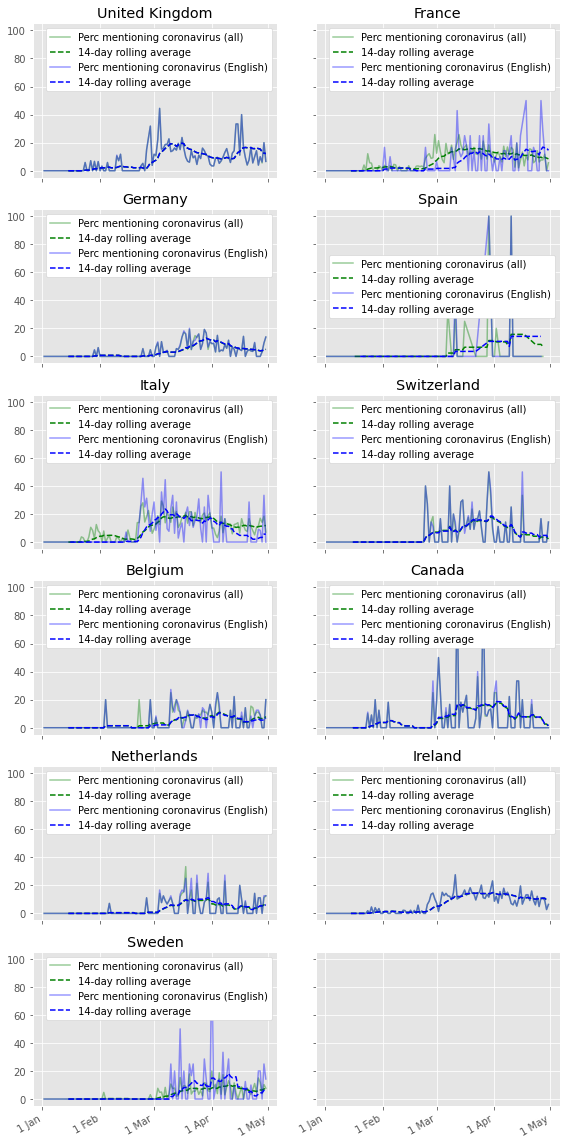

In [0]:
## Summarise and plot proportion of posts mentioning coronavirus over time

# Define function 

def plot_mentions(country, row, col, roll_time):

  for i in range(2):

    if i == 0:
      df = reddit['submissions'][country] # All posts
    else:
      df = reddit_polarity['submissions'][country] # English-only posts

    df = df[df['created_date'] < datetime(2020, 5, 1)]
    df = df[df['created_date'] > datetime(2020, 1, 1)]

    daily_posts = df.groupby('created_date').size()
    daily_mentions = df.groupby('created_date')['coronavirus_mentioned'].sum()
    perc_mentions = daily_mentions / daily_posts 
    perc_mentions = perc_mentions * 100
    mentions_roll = perc_mentions.rolling(roll_time).mean()

    if i == 0:
      axs[row, col].plot(perc_mentions, 'g', label = "Perc mentioning coronavirus (all)", alpha = 0.4)
      axs[row, col].plot(mentions_roll, 'g--', label = str(roll_time) + "-day rolling average")
    else:
      axs[row, col].plot(perc_mentions, 'b', label = "Perc mentioning coronavirus (English)", alpha = 0.4)
      axs[row, col].plot(mentions_roll, 'b--', label = str(roll_time) + "-day rolling average")

  axs[row, col].xaxis.set_major_formatter(my_format)
  axs[row, col].xaxis.set_major_locator(months)
  axs[row, col].xaxis.set_minor_locator(months)
  axs[row, col].legend()
  axs[row, col].set_title(capitalise_country[country])

# Graph mentions of coronavirus over time

plt.style.use('ggplot')

fig, axs = plt.subplots(6, 2, 
                        sharex = True,
                        sharey = True,
                        figsize = (8, 16))

index = 0

for country in countries:
  row, col = divmod(index, 2)
  plot_mentions(country, row, col, roll_time = 14)
  index = index + 1

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

We plot the percentage of submissions mentioning coronavirus in all languages and in English separately. We can see a similar evolution over time, mainly due to the predominence of English on Reddit. Thus, we have no reason to believe the English subsample to be unrepresentative, and will focus on this subsample in the rest of the analysis.

In the next cell, we plot the evolution of the sentiment of Reddit posts over time, but this time separating posts into whether they mention coronavirus over time or not.

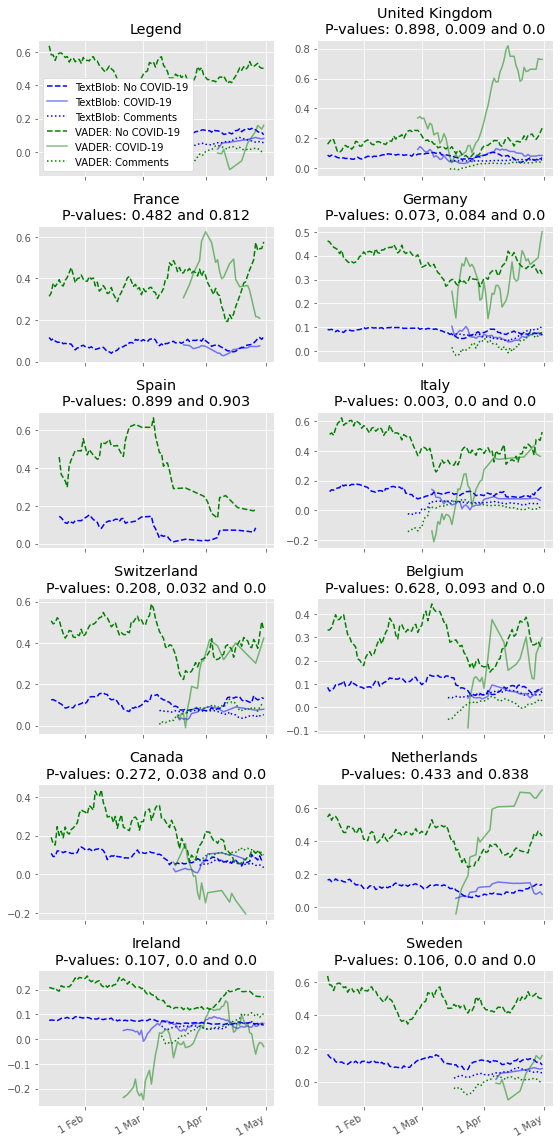

In [0]:
## Sentiment of posts mentioning coronavirus vs not mentioning it 

# Define function 

def plot_polarity_mentions(country, row, col, roll_time, legend = False):

  # Create df

  df = reddit_polarity['submissions'][country]
  df = df[df['created_date'] >= '2020-01-01']
  df = df[df['created_date'] <= '2020-04-30']

  # Tests for difference in means

  # TextBlob polarity for posts mentioning coronavirus and posts not mentioning it
  p_tb = ttest_ind(df[df['coronavirus_mentioned'] == 0]['tb_polarity'],
            df[df['coronavirus_mentioned'] == 1]['tb_polarity'])
  p_tb = round(p_tb[1], 3)

  # VADER polarity for post mentioning coronavirus and posts not mentioning it
  p_vader = ttest_ind(df[df['coronavirus_mentioned'] == 0]['vader_polarity'],
            df[df['coronavirus_mentioned'] == 1]['vader_polarity'])
  p_vader = round(p_vader[1], 3)

  # Calculate polarity - TextBlob polarity by mention of coronavirus

  tb_0 = df[df['coronavirus_mentioned'] == 0].groupby('created_date')['tb_polarity'].mean()
  tb_1 = df[df['coronavirus_mentioned'] == 1].groupby('created_date')['tb_polarity'].mean()
  tb_0 = tb_0.rolling(roll_time).mean()
  tb_1 = tb_1.rolling(roll_time).mean()

  # Calculate polarity - VADER polarity by mention of coronavirus

  vader_0 = df[df['coronavirus_mentioned'] == 0].groupby('created_date')['vader_polarity'].mean()
  vader_1 = df[df['coronavirus_mentioned'] == 1].groupby('created_date')['vader_polarity'].mean()
  vader_0 = vader_0.rolling(roll_time).mean()
  vader_1 = vader_1.rolling(roll_time).mean()

  # Comments

  if country in reddit_polarity['comments'].keys():
    
    # Create df
    comments = reddit_polarity['comments'][country]
    comments = comments[comments['created_date'] >= '2020-01-01']
    comments = comments[comments['created_date'] <= '2020-04-30']

    # Calculate polarities
    tb = comments.groupby('created_date')['tb_polarity'].mean()
    tb = tb.rolling(roll_time).mean()
    vader = comments.groupby('created_date')['vader_polarity'].mean()
    vader = vader.rolling(roll_time).mean()

    # Test for a difference in means with submissions - VADER polarity
    p_comments = ttest_ind(df['vader_polarity'], comments['vader_polarity'])
    p_comments = round(p_comments[1], 3)

  # Plot everything

  axs[row, col].plot(tb_0, 'b--', label = "TextBlob: No COVID-19")
  axs[row, col].plot(tb_1, 'b-', label = "TextBlob: COVID-19", alpha = 0.5)
  if country in reddit_polarity['comments'].keys():
    axs[row, col].plot(tb, 'b:', label = "TextBlob: Comments")

  axs[row, col].plot(vader_0, 'g--', label = "VADER: No COVID-19")
  axs[row, col].plot(vader_1, 'g-', label = "VADER: COVID-19", alpha = 0.5)
  if country in reddit_polarity['comments'].keys():
    axs[row, col].plot(vader, 'g:', label = "VADER: Comments")

  # Format graph and show

  if legend == False:
    if country in reddit_polarity['comments'].keys():
      axs[row, col].set_title(capitalise_country[country] +
                              "\nP-values: " + str(p_tb) + ", " + str(p_vader) + " and " + str(p_comments))
    else:
      axs[row, col].set_title(capitalise_country[country] + 
                              "\nP-values: " + str(p_tb) + " and " + str(p_vader))
  if legend == True:
    axs[row, col].legend()
    axs[row, col].set_title("Legend")
  axs[row, col].xaxis.set_major_formatter(my_format)
  axs[row, col].xaxis.set_major_locator(months)
  axs[row, col].xaxis.set_minor_locator(months)

# Plot

plt.style.use('ggplot')

fig, axs = plt.subplots(6, 2, 
                        sharex = True,
                        figsize = (8, 16))

plot_polarity_mentions('sweden', 0, 0, roll_time = 14, legend = True) # Plot legend in first subplot

index = 1

for country in reddit_polarity['submissions'].keys():
  row, col = divmod(index, 2)
  plot_polarity_mentions(country, row, col, roll_time = 14)
  index = index + 1

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In line with the previous results, we can see that the VADER scores lie consistently above the TextBlob scores for submissions.

We run a t-test to see whether the polarity scores are significantly different for entries with and without mentions of the coronavirus. We do this using both TextBlob (first p-value) and VADER (second p-value) scores for submissions.

The results are significant for a few countries. 
In the United Kingdom, submissions which mention coronavirus are significantly more positive than those which do not, based on VADER scores.
The opposite relationship can be found in Italy (for both TextBlob and VADER scores), Switzerland, Canada, Ireland, and Sweden (for VADER scores only).

Finally, we can observe that comments are on average more negative than submissions. We run a t-test to check whether the VADER score of submissions and comments is equal, and report the result as the third p-value.
We can see that the difference is statistically significant for all countries which have both comments and submissions. 

### 3.2.2. Words associated with mentions of coronavirus

In this part, we look for words that are associated with mentions of coronavirus, using a Naive Bayes classifier.

First, we create one full dataframe which contains all the submissions and comments, instead of different dataframes stored in dictionaries. We merge this full dataframe with the data on government measures based on date and country. We also merge the phases we had manually defined above.

In [0]:
## Create one full data frame with all the countries

## Prepare stringency dataframe for merge 

# Get the stringency column
stringency = gov_measures[['Date', 'CountryName', 'StringencyIndexForDisplay']]
stringency = stringency[stringency['CountryName'].isin(country_list)]

# Print the NaNs - No NaNs
loc_na = stringency[stringency['StringencyIndexForDisplay'].isnull()]
print(loc_na) # Emtpy dataframe

# Change name of column
stringency.columns = ['Date', 'CountryName', 'stringency']

## Create polarity_full data frame

polarity_full = pd.DataFrame()

for doc_type in reddit_polarity:

  for country in reddit_polarity[doc_type].keys():

    # Get data frame for country and keep only 2020
    df = reddit_polarity[doc_type][country]
    df = df[df['created_date'] >= '2020-01-01']
    df = df[df['created_date'] <= '2020-04-30']

    # Add columns
    df['country'] = country
    df['doc_type'] = doc_type 

    # Keep columns
    df = df[['created_date', 'country', 'doc_type', 'full_text', 'language', 
         'tokens', 'no_stops', 'stemmed', 'stemmed_join', 
         'vader_polarity', 'tb_polarity', 'coronavirus_mentioned']]

    polarity_full = polarity_full.append(df)

## Merge polarity_full and stringency

polarity_full['CountryName'] = polarity_full['country'].map(capitalise_country)
polarity_full['Date'] = polarity_full['created_date']

gov_measures_sub = gov_measures[['Date', 'CountryName',
                                'ConfirmedCases', 'ConfirmedDeaths', 
                                'NewCases', 'NewDeaths', 
                                'StringencyIndexForDisplay',
                                'C1_School closing', 
                                'C2_Workplace closing', 
                                'C3_Cancel public events', 
                                'C4_Restrictions on gatherings',
                                'C5_Close public transport',
                                'C6_Stay at home requirements', 
                                'C7_Restrictions on internal movement', 
                                'C8_International travel controls', 
                                'H1_Public information campaigns']]

polarity_full = polarity_full.merge(gov_measures_sub, how = 'left', on = ['Date', 'CountryName'])
polarity_full = polarity_full.merge(stringency, how = 'left', on = ['Date', 'CountryName'])

## Merge with phases

phases['Date'] = phases.index

phases_melted = pd.melt(phases, 
                        id_vars=['Date'], 
                        value_vars = country_list, 
                        var_name = "CountryName",
                        value_name = "phase")

polarity_full = polarity_full.merge(phases_melted, how = 'left', on = ['Date', 'CountryName'])

## Look at data frame

polarity_full.head()

Empty DataFrame
Columns: [Date, CountryName, StringencyIndexForDisplay]
Index: []


,created_date,country,doc_type,full_text,language,tokens,no_stops,stemmed,stemmed_join,vader_polarity,tb_polarity,coronavirus_mentioned,CountryName,Date,ConfirmedCases,ConfirmedDeaths,NewCases,NewDeaths,StringencyIndexForDisplay,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,stringency,phase
0,2020-01-01,uk,submissions,Am I SOL or are NHS dentists just useless? Idk...,en,"[am, i, sol, or, are, nhs, dentists, just, use...","[sol, nhs, dentists, useless, idk, place, post...","[sol, nhs, dentist, useless, idk, place, post,...",sol nhs dentist useless idk place post yeah ar...,-0.9466,-0.054468,0,United Kingdom,2020-01-01,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-01,uk,submissions,"Post Brexit, can UK join unincorporated territ...",en,"[post, brexit, can, join, unincorporated, terr...","[post, brexit, join, unincorporated, territori...","[post, brexit, join, unincorpor, territori, un...",post brexit join unincorpor territori unit sta...,0.7845,0.500000,0,United Kingdom,2020-01-01,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-01,uk,submissions,Jobs with a canadian BSC/MSC in psychology I a...,en,"[jobs, with, a, canadian, in, psychology, i, a...","[jobs, canadian, psychology, starting, univers...","[job, canadian, psycholog, start, univers, nex...",job canadian psycholog start univers next year...,-0.0433,0.150000,0,United Kingdom,2020-01-01,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-01,uk,submissions,The New Year Doctor Who episode While it’s a g...,en,"[the, new, year, doctor, who, episode, while, ...","[new, year, doctor, episode, good, episode, lo...","[new, year, doctor, episod, good, episod, love...",new year doctor episod good episod love doctor...,0.9712,0.237662,0,United Kingdom,2020-01-01,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-01,uk,submissions,Why does this sub have such a bad racism/preju...,en,"[why, does, this, sub, have, such, a, bad, pro...","[sub, bad, problem, curious, see, shit, ton, o...","[sub, bad, problem, curious, see, shit, ton, o...",sub bad problem curious see shit ton overt dog...,-0.8299,-0.202381,0,United Kingdom,2020-01-01,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we need to transform the list of stemmed tokens into numerical features that can be used in our naive Bayes classifier.

We use two different representations: bag-of-words and tf-idf (term frequency-inverse document frequency).

In the next cell, we show what a bag-of-words representation of text data looks like.

In [0]:
## Introduction: Bag of words (BOW)

df = polarity_full

vect = CountVectorizer(ngram_range=(1,2),
                       max_features = 500) # Uni- and bigrams, only 500 features for demonstration

vect.fit(df['stemmed_join'])
X = vect.transform(df['stemmed_join'])
X_df = pd.DataFrame(X.toarray(), 
                    columns = vect.get_feature_names())
X_df

,10,20,abl,absolut,accept,account,actual,advic,age,ago,agre,allow,almost,alreadi,also,alway,amount,announc,anoth,answer,anyon,anyth,anyway,apart,appli,appreci,area,around,articl,ask,assum,avail,avoid,away,back,bad,bank,base,basic,becom,...,use,usual,vaccin,video,virus,visit,vote,vulner,wait,walk,want,wash,watch,way,wear,websit,week,weekend,well,went,whether,whole,within,without,wo,wonder,word,work,work home,worker,world,worri,wors,would,wrong,yeah,year,yes,yesterday,yet
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157758,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157761,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Each row represents a publication, and each column a given token. The values represent the count of words for each publication.
For example, we can see that obervation 3 mentions the stemmed token "abl" once.

In [0]:
## Introduction: Term frequency - Inverse document frequency (TFIDF)

df = polarity_full

vect = TfidfVectorizer(ngram_range=(1,2),
                       max_features = 500) # Uni- and bigrams, only 500 features for demonstration

vect.fit(df['stemmed_join'])
X = vect.transform(df['stemmed_join'])
X_df = pd.DataFrame(X.toarray(), 
                    columns = vect.get_feature_names())
X_df

,10,20,abl,absolut,accept,account,actual,advic,age,ago,agre,allow,almost,alreadi,also,alway,amount,announc,anoth,answer,anyon,anyth,anyway,apart,appli,appreci,area,around,articl,ask,assum,avail,avoid,away,back,bad,bank,base,basic,becom,...,use,usual,vaccin,video,virus,visit,vote,vulner,wait,walk,want,wash,watch,way,wear,websit,week,weekend,well,went,whether,whole,within,without,wo,wonder,word,work,work home,worker,world,worri,wors,would,wrong,yeah,year,yes,yesterday,yet
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193813,0.0,0.0,0.0,0.0,0.106467,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.093791,0.0,0.000000,0.0,0.0,0.0,0.215452,0.174774,0.000000,0.0,0.0,0.0,0.0,...,0.085947,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.121015,0.0,0.151828,0.0,0.0,0.112658,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.103893,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.210947,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.351360,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.167892,0.0,0.000000,0.178048,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.216977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.178341,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.151825,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.165652,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.205946,0.153666,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.153919,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.394317,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157758,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
157759,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.180715,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
157760,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0

The matrix looks very similar to the bag-of-words matrix.

However, instead of representing the word count, the values are the term frequency-inverse document frequency. Intuitively, this approach takes into account the fact that some words are very common in all types of texts (and will have a high document frequency), and therefore are not very informative. 

More information on how the tf-idf matrix is computed is available on the [scikit-learn website](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

Next, we create a column with no mentions of coronavirus, based on the pre-processed and stemmed tokens. We remove the words "coronavirus", "COVID-19" and equivalents from the stemmed tokens. This column will be used to create our features.

In [0]:
## Create no coronavirus column (text without mentions of coronavirus) to predict mentions of coronavirus

# Only submissions

polarity_submissions = polarity_full[polarity_full['doc_type'] == "submissions"]

# Define the function

def remove_coronavirus(text_column):

  coronavirus_removed = []

  for row in text_column:    
    no_coronavirus = [word for word in row if word not in coronavirus_names]
    join_row = " ".join(t for t in no_coronavirus) # Return a string
    coronavirus_removed.append(join_row)

  return(pd.Series(coronavirus_removed))

# Run the function

polarity_submissions['no_coronavirus'] = remove_coronavirus(polarity_submissions['stemmed'])

# Check no NaNs

print(any(polarity_submissions['no_coronavirus'].isna())) # False
print(any(polarity_submissions['coronavirus_mentioned'].isna())) # False

print("Complete.")

False
False
Complete.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In the next cell, we count the number of submissions with and without mentions of coronavirus.

In [0]:
## Value counts

df = polarity_submissions[polarity_submissions['created_date'] >= '2020-01-01']
print("Value counts:")
print(df['coronavirus_mentioned'].value_counts())
print("Percentage:" )
print(round(100 * df['coronavirus_mentioned'].value_counts() / len(df['coronavirus_mentioned']), 1))

Value counts:
0    19773
1     1453
Name: coronavirus_mentioned, dtype: int64
Percentage:
0    93.2
1     6.8
Name: coronavirus_mentioned, dtype: float64


We can see that 93% of the data set is composed by submissions which do not mention coronavirus, for the period ranging from 1st January 2020 to 30th April 2020. 
The data is therefore very imbalanced, which needs to be kept in mind in the rest of the analysis.

In the following three cells, we create functions that will be used later in the analysis.

First, we create a pipeline, which is a list of transform we apply to create a final estimator. This pipeline will be passed as argument to the `cross_validate` function from the scikit-learn package.

In [0]:
## Define function to create pipeline


# Get vectorizer based on method

def get_vect(method):

  if method == "BOW":
    vect = CountVectorizer(max_features = 5000, ngram_range=(1, 2))
    return(vect)

  elif method == "TFIDF":
    vect = TfidfVectorizer(max_features = 5000, ngram_range=(1, 2))
    return(vect)


# Get classifier 

def get_clf(classifier):

  if classifier == "naive bayes":
    clf = MultinomialNB()
    return(clf)

  if classifier == "decision tree":
    clf = DecisionTreeClassifier()
    return(clf)

  if classifier == "random forest":
    clf = RandomForestClassifier()
    return(clf)


# Full function

def get_pipeline(classifier, method, resample = True):

  # Choose BOW/TFIDF
  vect = get_vect(method)
  
  # Prepare intermediate steps
  sm = SMOTE(random_state = 123)

  # Classifier
  clf = get_clf(classifier)

  ## Make pipeline ##

  # With resample
  if resample == True:
    pipe = Pipeline([('vect', vect),
                    ('sm', sm),
                    ('clf', clf)])
    return(pipe)

  # Without resample
  else:
    pipe = Pipeline([('vect', vect),
                     ('clf', clf)]) 
    return(pipe)   

print("Complete.")

Complete.


The pipeline takes three steps. First, it creates a bag-of-words or tf-idf representation of the text data, depending on which `method` we specify. Secondly, it implements `SMOTE`, which oversamples the underrepresented classes to deal with the imbalance in our data set. Finally, it applies either the multinomial naive Bayes classifier, or a decision tree, or a random forest, depending on which `classifier` we specify.

In the next cell, we define a function which prints key metrics, in the case we use a hold-out test set approach, for a binary target.

In [0]:
## Define function to print metrics (train/test split)

def print_metrics(classifier, X_test, y_test, y_pred):

  print("Accuracy score:", round(accuracy_score(y_test, y_pred), 2))
  print("Balanced accuracy score:", round(balanced_accuracy_score(y_test, y_pred), 2))
  print("F1 score:", np.round(f1_score(y_test, y_pred, average = None), 2))
  print("Confusion matrix:")
  conf_mat = plot_confusion_matrix(classifier, X_test, y_test, 
                                   cmap = plt.cm.Blues, normalize = "true")
  conf_mat.ax_.set_title("Confusion matrix")
  plt.show()

We also define a function which prints key metrics based on `cv_scores`, the dictionary returned by the `cross_validate` function.

The metrics chosen are:
* **Accuracy**: fraction of correct predictions
* **Balanced accuracy**: raw accuracy where each sample is weighted according to the inverse prevalence of its true class
* **F1 score**: weighted harmonic mean of precision (number of true positives divided by the sum of true and false positives) and recall (number of true positives divided by the sum of true positive and false negatives)
  * **Macro-averaged**: calculates metrics for each label, and find their unweighted mean (does not take imbalance into account)
  * **Micro-averaged**: calculates metrics globally by counting the total true positives, false negatives, and false positives

More information on the precise computation method of these metrics is available on the [scikit-learn website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [0]:
## Define function to print CV scores

def print_cv_scores(cv_scores):

  print("Accuracy score:", np.round(cv_scores['test_accuracy'], 2))
  print("Balanced accuracy score", np.round(cv_scores['test_balanced_accuracy'], 2))
  print("F1 Micro score:", np.round(cv_scores['test_f1_micro'], 2))
  print("F1 Macro score:", np.round(cv_scores['test_f1_macro'], 2))

Finally, we create a function which predicts whether coronavirus is mentioned in a submission based on other words used in that submission. The function takes either `BOW` (bag-of-words) or `TFIDF` (term frequency-inverse document frequency) as a `method` used to featurise the text data.

In [0]:
## Predict mentions of coronavirus using other words - Create function

def predict_mentions(method):

  # Time it 
  start_time = time()

  # Limit the time frame to 2020 only
  df = polarity_submissions[polarity_submissions['created_date'] >= '2020-01-01']

  # Define X and y
  X = df['no_coronavirus']
  y = df['coronavirus_mentioned']

  # Get pipeline
  pipe = get_pipeline(classifier = "naive bayes",
               method = method, 
               resample = True)

  ## Cross-validation ##

  # Cross validate
  cv_scores = cross_validate(pipe, X, y, cv = 5,
                            scoring = ['accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro'])
  
  # CV metrics
  print("\n\nCross-validation:\n")
  print_cv_scores(cv_scores)
  print("\n")

  ## Train/test split (to get confusion matrix) ##
  
  # Split into training and test sample
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size = 0.33,
                                                      random_state = 123)
  
  # Fit and get predictions
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)

  # Print metrics
  print("\nHold-out test sample:\n")
  print_metrics(pipe, X_test, y_test, y_pred)

  # Get coefficients
  coefs = pd.DataFrame(pipe.named_steps['clf'].coef_,
                      columns = pipe.named_steps['vect'].get_feature_names())

  # Transpose and sort
  coefs = coefs.transpose()
  coefs = coefs.sort_values(by = 0, axis = 0, ascending = False)
  coefs.reset_index(inplace = True, drop = False)

  # Make positive numbers - Add minimum
  coefs[0] = coefs[0] - coefs[0].min()
  names = coefs['index']

  # Plot most positive coefficients
  print("\nLargest coefficients:")
  plt.bar(range(15), coefs.iloc[0:15][0])
  plt.xticks(range(15), names[0:15], rotation = 60)
  plt.ylabel('Coefficients (normalised with min = 0)')
  plt.title("Naive Bayes (" + method + ") - Largest coefficients")
  plt.show()

  # Print time

  total_time = round(time() - start_time)
  m, s = divmod(total_time, 60)
  print(f'Total run time: {m:02d} minutes and {s:02d} seconds') 

print("Complete.")

Complete.


In the next two cells, we call the previously defined function for both bag-of-words and tf-idf representations.

First, we conduct the analysis using a bag-of-words representation and the multinomial naive Bayes classifier. 



Cross-validation:

Accuracy score: [0.89 0.93 0.93 0.92 0.92]
Balanced accuracy score [0.59 0.51 0.53 0.52 0.51]
F1 Micro score: [0.89 0.93 0.93 0.92 0.92]
F1 Macro score: [0.58 0.51 0.53 0.53 0.5 ]



Hold-out test sample:

Accuracy score: 0.93
Balanced accuracy score: 0.54
F1 score: [0.96 0.16]
Confusion matrix:


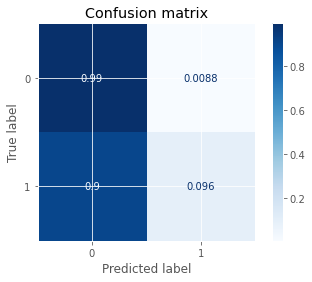


Largest coefficients:


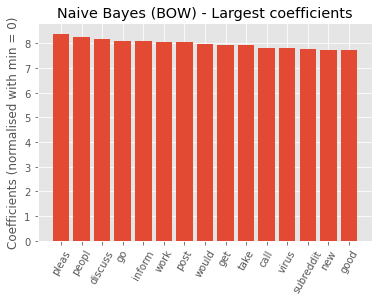

Total run time: 01 minutes and 22 seconds


In [0]:
# BOW

if toggle_on:  
  
  predict_mentions("BOW") 

# Total run time: 01 minutes and 13 seconds

Although the accuracy is quite high (over 90%), we can see that the model performs poorly when looking at the confusion matrix. This is because of the imbalance in the data set: submissions mentioning coronavirus represent less than 7% of the entire sample, meaning that it is possible to achieve an accuracy of 93% by predicting "no mention of coronavirus" for all submissions.

Thus, it is necessary to consider alternative metrics, such as the balanced accuracy score or the F1 score. They confirm that this simple model fails to predict which posts indeed mention coronavirus.

Next, we retrieve the coefficients of the Naive Bayes classifier, and plot the largest coefficients. These are tokens that are the most associated with submissions that do mention coronavirus. Although we believe that the word "virus" is a reasonable predictor, most of these words are quite generic, and we expect them to also be often present in submissions which do not mention coronavirus (words such as "please", "discuss", "new" or "good"). 

Secondly, we use the tf-idf representation instead of the bag-of-words method.




Cross-validation:

Accuracy score: [0.81 0.9  0.87 0.81 0.81]
Balanced accuracy score [0.75 0.63 0.68 0.7  0.67]
F1 Micro score: [0.81 0.9  0.87 0.81 0.81]
F1 Macro score: [0.61 0.62 0.63 0.59 0.58]



Hold-out test sample:

Accuracy score: 0.86
Balanced accuracy score: 0.72
F1 score: [0.92 0.36]
Confusion matrix:


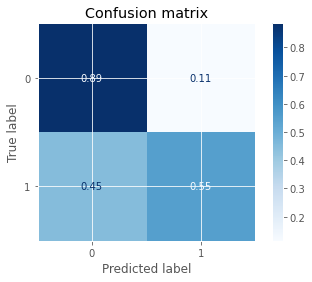


Largest coefficients:


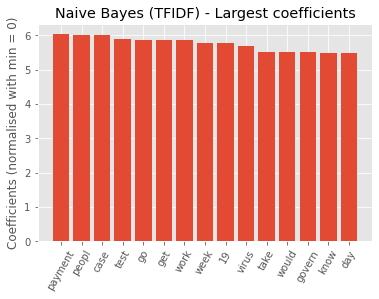

Total run time: 01 minutes and 22 seconds


In [0]:
# TFIDF

if toggle_on:
    
  predict_mentions("TFIDF")

# Total run time: 1 minute and 15 seconds

Although imbalance remains a problem with the tf-idf representation, this model is better at predicting mentions of coronavirus when they do occur, with a rate of true positives at 55% instead of 10%.
This is achieved at the cost of a higher rate of false positives (11% instead of less than 1%). 

The largest coefficients also seem to be more directly related to coronavirus than for the model using a bag-of-words featurisation. Indeed, words such as "case" (in the phrase "number of confirmed cases" for example), "test", "virus", "19" (as in "COVID-19") seem to be more specific to coronavirus.

Thus, overall, despite the lower accuracy of this model, we believe it is better than the previous one, because of the much lower rate of false negatives.

## 3.3. Predicting stringency phase based on word use

Finally, we tackle our third research question: *Is it possible to predict the level of government measures using Reddit submissions?*

First, we prepare the data set and define our dependent variables. 

Next, we implement and compare three different methods, namely:
1. Naive Bayes
2. Decision tree
3. Random forest

In the next cell, we check whether the data is balanced, and if there are any missing values.

In [0]:
## Check if balanced data and NAs

df = polarity_submissions

# Stemmed
print("Stemmed join")
print(any(df['stemmed_join'].isna())) # Check NAs - False

# Phase
print("\nPhase")
counts = df['phase'].value_counts()
print(counts) # Need to drop phase 0 and phase 4 - not enough data
print(any(df['phase'].isna())) # Check NAs - False

# Stay at home requirements
print("\nStay-at-home requirements")
counts = df['C6_Stay at home requirements'].value_counts()
print(counts)
print(any(df['C6_Stay at home requirements'].isna())) # Check NAs - False

# Divide in 4 categories - for approx balanced data
print("\nStringency categories")
print("Quartiles:")
print("Q1:", np.quantile(df['stringency'], 0.25))
print("Q2 (median):", np.quantile(df['stringency'], 0.50))
print("Q3:", np.quantile(df['stringency'], 0.75))

def get_categories(col):
  y = []
  for row in col:
    if row <= np.quantile(col, 0.25):
      y.append(0)
    elif row <= np.quantile(col, 0.50):
      y.append(1)
    elif row <= np.quantile(col, 0.75):
      y.append(2)
    else:
      y.append(3)
  return(pd.Series(y))

y = get_categories(df['stringency'])

print(y.value_counts())
print(any(y.isna())) # Check NAs - False

Stemmed join
False

Phase
3.0    6391
0.0    5472
1.0    4694
2.0    4598
4.0      71
Name: phase, dtype: int64
False

Stay-at-home requirements
0.0    13588
2.0     6455
1.0     1013
3.0      170
Name: C6_Stay at home requirements, dtype: int64
False

Stringency categories
Quartiles:
Q1: 2.78
Q2 (median): 20.37
Q3: 74.54
0    5455
1    5379
3    5267
2    5125
dtype: int64
False


There are no missing values for any of the variables of interest.

We can see that for the "phase" variable, only few observations are in phase 4. Thus, in the next cell, we drop these observations from the analysis, and focus on the remaining four phases. Phases 0 to 3 are relatively well-balanced in the data set, which suggests that accuracy can be used as a metric to evaluate the performance of our models.

For the stay-at-home requirements, we also observe imbalance in the data. To deal with this, in the next cell, we create a binary variable which is equal to 1 if the variable is 1, 2, or 3, and 0 otherwise. The data will still remain imbalanced, but less so than originally.

Finally, we define a "category" variable, by dividing the stringency index into four quartiles. We use this variable as an alternative target variable in the sensitivity analysis of this project.

In the next cell, we define a function which automatically creates two pandas series `X` (each row is a string of stemmed tokens) and `y`, which are the key variables in the analysis

In [0]:
## Define function to get variables

def get_variables(y_var, x_var = "stemmed_join"):

  # Get the data set
  df = polarity_submissions

  # Stringency
  if y_var == "stringency":
    y = df['stringency']

  # Stringency categories 
  elif y_var == "category":
    y = get_categories(df['stringency'])

  # Phase
  elif y_var == "phase":
    df = df[df['phase'] != 4] # Drop phases that do not have enough data
    # Drop them from df, so also dropped for X
    y = df['phase']
  
  # Stay at home requirements
  elif y_var == "stay at home":
    y = []
    for row in df['C6_Stay at home requirements']:
      y.append(1 if row >= 1 else 0)
    y = pd.Series(y)

  # Else
  else:
    y = df[y_var]

  # Define X
  if x_var == "stemmed_join":
    X = df['stemmed_join'] # Some observations dropped based on y_var
  else:
    X = df[x_var]

  # Return 
  return(X, y)

print("Complete.")

Complete.


### 3.3.1. Naive Bayes

First, we present the results using the Naive Bayes classifier.

In the next cell, we create a dictionary which will store the cross-validated scores for the different variables we will use in the analysis. We use cross-validation to get scores that are not prone to over-fitting, and more likely to represent the true performance of the model on unseen data.

In [0]:
# Create a dictionary to store the scores

scores = {
    'phase': {},
    'category': {},
    'stay at home': {}
}

Next, we define a function which returns the cross-validated scores and coefficients for the naive Bayes classifier.
We save this output in a separate file to be retrieved later instead of running the code every single time, to save computational power and time.

In [0]:
## Cross-validation score for naive Bayes

def naive_bayes(y_var, method):

  # Time it 
  start_time = time()

  # Get the variables
  X, y = get_variables(y_var)

  # Get pipeline
  pipe = get_pipeline(classifier = "naive bayes", method = method, resample = True)

  # Cross validate
  cv_scores = cross_validate(pipe, X, y, cv = 5,
                            scoring = ['accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro'])
  print("\nCross-validated metrics:")
  print_cv_scores(cv_scores)

  # Fit
  pipe.fit(X, y)

  # Get coefficients
  coefs = pd.DataFrame(pipe.named_steps['clf'].coef_,
                      columns = pipe.named_steps['vect'].get_feature_names())
  
  # Add standard deviation 
  st_dev = np.std(coefs)
  st_dev.name = "st_dev"
  coefs = coefs.append(st_dev)

  # Save output

  path = directory + 'Output/'

  filename = path + y_var + '_' + 'naive bayes' + '_' + method.lower() + '_scores'
  outfile = open(filename, 'wb')
  pickle.dump(cv_scores, outfile)
  outfile.close()

  filename = path + y_var + '_' + 'naive bayes' + '_' + method.lower() + '_coefs'
  outfile = open(filename, 'wb')
  pickle.dump(coefs, outfile)
  outfile.close()

  filename = path + y_var + '_' + 'naive bayes' + '_' + method.lower() + '_pipeline'
  outfile = open(filename, 'wb')
  pickle.dump(pipe, outfile)
  outfile.close()
  
  # Print time
  total_time = round(time() - start_time)
  m, s = divmod(total_time, 60)
  print(f'Total run time: {m:02d} minutes and {s:02d} seconds') 

  # Sort by standard deviation and return coefficients
  return(cv_scores, 
         coefs.sort_values(by = "st_dev", axis = 1, ascending = False),
         pipe)

print("Complete.")

Complete.


In the next cell, we call the previously defined function, using a bag-of-words representation.

In [0]:
# Naive Bayes - BOW

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Run the function - Automatically save results
  cv_scores, coefs, pipe = naive_bayes("phase", "BOW")

# Total run time: 00 minutes and 46 seconds

To run the content of this cell, please change the if condition to True.


Finally, we define and call a function which returns a dataframe with the key metrics. 

In [0]:
# BOW - Print metrics 

def df_cv_scores(y_var, clf, method, get_df = True):
  
  path = directory + 'Output/'
  filename = path + y_var + '_' + clf + '_' + method.lower() + '_scores'
  infile = open(filename,'rb')
  scores[y_var][clf + '_' + method.lower()] = pickle.load(infile)
  infile.close()

  if get_df == True:
    df = pd.DataFrame(scores[y_var][clf + '_' + method.lower()])
    means = df.mean()
    means = pd.Series(means, name = "Mean")
    df = df.append(means)
    df = df.round(2)
    return(df)

df_cv_scores("phase", "naive bayes", "BOW")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_micro,test_f1_macro
0,8.50,0.36,0.33,0.34,0.33,0.33
1,7.77,0.35,0.26,0.26,0.26,0.23
2,7.75,0.33,0.39,0.40,0.39,0.38
3,7.88,0.29,0.41,0.43,0.41,0.40
4,7.94,0.29,0.36,0.36,0.36,0.35
Mean,7.97,0.33,0.35,0.36,0.35,0.34


We can see that the mean accuracy across the five folds is 36%, which is low. The other metrics are not more convincing, suggesting that the model performs poorly.

Next, we define a function to plot the confusion matrix for the model. To do so, we divide the sample into a training and testing set and redo the analysis, in order to avoid unrealistically high scores due to overfitting.

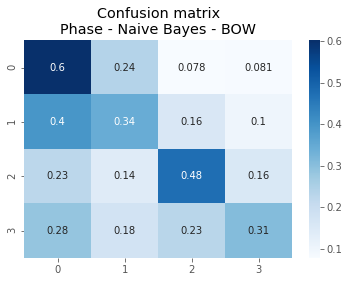

Total run time: 0 hours, 00 minutes and 07 seconds


In [0]:
## Define function to plot confusion matrix

def show_conf_mat(y_var, clf, method):

  # Time it
  start_time = time()

  # Get the variables
  X, y = get_variables(y_var)

  # Get pipeline
  pipe = get_pipeline(clf, method, True)

  # Split into training and test sample
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size = 0.33,
                                                      random_state = 123)

  # Fit on training set
  pipe.fit(X_train, y_train)

  # Get predictions
  y_pred = pipe.predict(X_test)

  # Show confusion matrix
  conf_mat = confusion_matrix(y_test, y_pred, normalize = "true")
  sns.heatmap(conf_mat, annot = True, cmap = plt.cm.Blues)
  plt.title("Confusion matrix\n" + y_var.capitalize() + " - " + clf.title() + " - " + method.upper())
  plt.show()

  # Print time
  total_time = round(time() - start_time)
  m, s = divmod(total_time, 60)
  h, m = divmod(m, 60)
  print(f'Total run time: {h} hours, {m:02d} minutes and {s:02d} seconds') 

show_conf_mat("phase", "naive bayes", "BOW")

We see that the model tends to mispredict phases that are relatively close to each other. For example, for phase 0, 24% of the true values are mistaken for belonging to phase 1. This is understandable, as we expect the content of Reddit submissions to evolve gradually rather than suddenly. 

More concerning is the high number of submissions in phase 2 or 3 that are mistaken for phase 0. This might be caused by the number of submissions on other topics than coronavirus, which might be misclassified as submissions written before the crisis. 

Next, we print the coefficients of the model, ordered by their standard deviation.

In [0]:
# BOW - Print coefficients

path = directory + 'Output/'

filename = path + 'phase_naive bayes_bow_coefs'
infile = open(filename,'rb')
coefs = pickle.load(infile)
infile.close()

coefs.sort_values(by = "st_dev", axis = 1, ascending = False)

,lockdown,covid,social distanc,2fannounc,view poll,sf,remov view,fáil,fianna fáil,poll station,ppe,2f 3a1337,2fannounc 3a,3a80,3a1337,3a1337 2fannounc,2f 3a80,3a80 2fannounc,ff,self isol,articl inform,fianna,3a 2f,sinn fein,submit new,test result,manifesto,discuss pleas,subreddit covid,green parti,glove,fein,magnet 3a,go supermarket,covid payment,covid discuss,swedish,physic contact,ask elder,ff fg,...,alreadi,time,lost,make,oh,get,higher,extend,last,ask,coupl,bad,back,aswel,without,decid,occur,know anyth,pick,around,averag,basic,need,woke,made,joke,initi,even,swear,posit,associ,begin,would rather,sent,bit,real,etc,know good,think,sure
0,-12.523784,-11.830637,-12.523784,-12.523784,-12.523784,-8.069437,-12.523784,-8.141758,-8.154336,-8.480733,-12.523784,-12.523784,-12.523784,-12.523784,-12.523784,-12.523784,-12.523784,-12.523784,-7.918614,-12.523784,-12.523784,-7.832436,-10.914346,-8.141758,-12.523784,-12.523784,-8.498433,-11.830637,-12.523784,-8.912866,-12.523784,-8.104944,-12.523784,-12.523784,-12.523784,-12.523784,-6.774391,-12.523784,-12.523784,-9.227947,...,-6.853903,-5.272439,-7.656250,-5.810828,-8.860223,-4.739311,-8.364901,-8.673637,-6.285460,-5.936234,-7.314298,-7.014396,-5.940375,-10.125889,-6.790443,-7.423918,-9.191580,-9.227947,-7.949073,-6.287415,-8.141758,-7.195908,-5.422108,-10.221199,-7.010356,-8.534800,-8.673637,-5.841676,-10.038878,-7.336398,-9.528052,-8.349397,-9.751196,-7.633435,-6.694839,-7.770194,-6.594195,-9.690571,-5.612037,-6.414537
1,-9.610730,-8.772401,-10.591559,-7.691971,-12.383319,-7.277373,-12.383319,-8.772401,-8.799800,-9.292276,-11.690172,-8.375986,-8.375986,-8.375986,-8.375986,-8.375986,-8.375986,-8.375986,-7.710490,-9.164443,-12.383319,-8.322876,-7.655931,-7.420474,-11.690172,-12.383319,-9.387587,-12.383319,-12.383319,-9.492947,-9.438880,-7.386107,-8.719757,-12.383319,-12.383319,-12.383319,-10.997024,-12.383319,-12.383319,-8.491499,...,-6.853890,-5.320271,-7.682838,-5.725308,-8.856958,-4.740795,-8.305781,-8.719757,-6.276296,-6.013418,-7.372684,-6.949597,-6.022016,-10.186094,-6.716892,-7.339894,-9.247825,-9.205265,-7.952502,-6.326535,-8.120639,-7.157572,-5.430590,-10.186094,-6.994247,-8.512118,-8.599129,-5.889565,-10.080734,-7.379373,-9.492947,-8.305781,-9.744262,-7.655931,-6.653219,-7.729358,-6.575176,-9.675269,-5.582036,-6.419740
2,-6.769605,-6.780339,-7.345365,-12.407960,-10.616200,-11.714813,-12.407960,-11.714813,-11.714813,-12.407960,-8.797042,-12.407960,-12.407960,-12.407960,-12.407960,-12.407960,-12.407960,-12.407960,-11.714813,-7.735131,-9.768903,-11.714813,-12.407960,-11.021666,-9.272466,-9.363437,-11.714813,-9.272466,-9.272466,-12.407960,-8.131294,-10.798522,-12.407960,-9.040664,-10.105375,-9.363437,-7.555930,-9.635371,-8.973973,-12.407960,...,-6.813248,-5.230177,-7.671761,-5.768084,-8.911452,-4.667295,-8.264825,-8.719080,-6.365327,-5.965420,-7.295972,-6.961223,-5.951190,-10.105375,-6.776748,-7.397325,-9.229906,-9.229906,-7.930623,-6.372478,-8.188452,-7.231810,-5.366548,-10.210735,-7.046668,-8.536759,-8.646760,-5.866930,-10.105375,-7.404014,-9.463521,-8.297086,-9.699910,-7.689461,-6.671388,-7.754000,-6.555757,-9.699910,-5.593417,-6.434150
3,-6.481441,-6.226445,-7.622432,-12.659385,-7.500329,-11.273090,-7.977253,-12.659385,-12.659385,-12.659385,-8.302676,-12.659385,-12.659385,-12.659385,-12.659385,-12.659385,-12.659385,-12.659385,-11.049947,-8.852722,-8.368925,-11.273090,-10.579943,-11.273090,-8.368925,-8.830743,-12.659385,-8.368925,-8.921715,-12.659385,-8.830743,-11.273090,-12.659385,-9.327180,-8.616333,-9.048467,-7.754110,-8.898185,-9.523890,-11.560772,...,-6.919592,-5.226309,-7.754110,-5.818838,-8.945813,-4.765067,-8.328651,-8.634033,-6.289484,-6.023438,-7.376181,-7.031764,-5.937959,-10.174478,-6.804313,-7.417638,-9.162877,-9.292089,-8.014994,-6.342220,-8.182048,-7.216967,-5.433903,-10.261489,-6.972409,-8.469730,-8.634033,-5.818838,-10.094435,-7.366080,-9.481331,-8.289937,-9.714946,-7.655438,-6.698379,-7.739404,-6.586340,-9.663652,-5.606664,-6.419109
st_dev,2.450177,2.194059,2.15062

We can see that the n-grams with the highest standard deviation are "lockdown", "covid", and "social distanc", which are directly related to the stringency of government measures, which is encouraging.

Next, we repeat the analysis using the tf-idf representation instead of bag-of-words.

In [0]:
# TFIDF

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Run the function - automatically saves results
  cv_scores, coefs, pipe = naive_bayes("phase", "TFIDF")

# Total run time: 00 minutes and 47 seconds

To run the content of this cell, please change the if condition to True.


In [0]:
# TFIDF - Print metrics 

df_cv_scores("phase", "naive bayes", "TFIDF")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_micro,test_f1_macro
0,7.94,0.36,0.33,0.34,0.33,0.33
1,7.84,0.35,0.25,0.24,0.25,0.23
2,7.89,0.33,0.41,0.41,0.41,0.39
3,8.07,0.29,0.42,0.43,0.42,0.41
4,8.04,0.29,0.36,0.36,0.36,0.35
Mean,7.95,0.33,0.35,0.36,0.35,0.34


The mean metrics are very similar to the bag-of-words approach. 

Next, we print the confusion matrix to get more insights into the performance of the model.

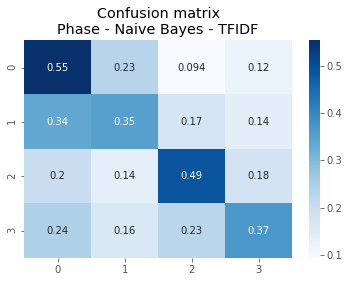

Total run time: 0 hours, 00 minutes and 07 seconds


In [0]:
# TFIDF - Print confusion matrix

show_conf_mat("phase", "naive bayes", "TFIDF")

Similar to the approach implementing the bag-of-words representation, we see that the model tends to confuse phase 0 and phase 1. 

Finally, we print the coefficients sorted based on their standard deviation.

In [0]:
# TFIDF - Print coefficients

path = directory + 'Output/'

filename = path + 'phase_naive bayes_tfidf_coefs'
infile = open(filename,'rb')
coefs = pickle.load(infile)
infile.close()

coefs.sort_values(by = "st_dev", axis = 1, ascending = False)

,lockdown,view poll,remov view,covid,social distanc,sf,sinn fein,fein,swedish,pandem,sinn,candid,covid19,ff,sweden,switzerland,covid 19,patrick day,self isol,fg,work home,elect,stay home,still open,infect,quarantin,wash hand,stockholm,glove,ppe,fianna,ff fg,covid payment,happi new,constitu,poll,new year,vulner,vote,clap,...,alreadi,procedur,term,play,last,finger,get,month,stori,give,network,need,like make,half,see,month would,make,sure,like take,year work,maintain,instead,mani,pint,decid,would grate,idea,noth,even,month ago,etc,scam,bit,think,lie,like get,realli hope,alon,money,well
0,-10.452682,-10.452682,-10.452682,-10.350191,-10.452682,-8.155521,-7.901118,-7.897079,-6.616907,-9.970426,-7.609613,-7.495429,-10.295089,-7.981092,-6.353419,-6.712482,-10.323422,-9.757886,-10.452682,-7.937439,-9.580742,-6.724885,-10.038153,-10.314968,-9.652426,-9.488722,-10.267492,-7.548045,-10.452682,-10.452682,-7.950493,-8.876362,-10.452682,-8.190290,-8.515999,-8.055300,-7.845386,-10.116359,-6.397743,-10.321083,...,-7.159051,-9.011550,-7.789010,-7.389077,-6.697654,-9.111977,-5.605487,-6.396979,-7.386434,-6.795799,-8.386613,-6.047804,-9.563001,-7.823189,-6.476315,-9.533730,-6.406015,-6.791197,-9.468332,-9.253585,-9.068837,-7.831717,-6.816086,-8.654854,-7.645306,-9.528155,-6.937048,-7.359816,-6.514828,-8.330669,-6.913612,-8.240835,-6.955850,-6.118240,-8.490615,-8.745053,-9.556005,-8.102657,-6.929853,-6.778865
1,-9.166759,-10.442204,-10.442204,-8.670875,-10.160688,-7.076022,-7.182495,-7.170689,-9.953059,-8.528412,-6.881524,-7.419476,-9.371148,-7.436643,-9.478251,-9.655471,-9.264303,-7.945792,-8.621731,-7.526629,-8.962946,-6.643760,-8.780015,-10.102687,-7.448580,-8.037614,-7.686577,-10.349528,-9.516709,-10.286116,-8.352930,-7.993786,-10.442204,-10.442204,-8.010474,-7.659798,-10.080236,-8.816506,-6.319722,-10.068917,...,-7.141889,-8.939082,-7.850829,-7.410138,-6.702740,-9.084914,-5.593942,-6.497801,-7.407224,-6.745461,-8.477675,-6.096934,-9.526811,-7.859058,-6.419654,-9.579575,-6.344270,-6.800041,-9.419496,-9.249559,-9.136365,-7.799364,-6.836934,-8.612012,-7.594335,-9.526369,-6.909066,-7.405358,-6.506446,-8.369741,-6.856784,-8.209447,-6.925171,-6.090796,-8.481038,-8.738104,-9.558619,-8.106216,-6.948728,-6.767772
2,-6.584859,-9.467769,-10.408121,-6.983632,-7.370980,-10.265596,-9.907715,-9.788634,-7.558805,-6.932297,-9.547637,-9.933154,-7.482713,-10.013682,-7.179540,-7.449577,-7.691395,-7.858239,-7.439497,-9.833454,-6.972342,-8.889933,-7.391308,-7.756739,-6.993988,-7.136302,-7.971868,-8.761047,-7.803026,-8.490672,-10.140978,-10.408121,-9.406497,-10.408121,-10.040582,-9.068210,-9.925397,-7.617710,-8.255016,-9.561744,...,-7.137635,-8.901236,-7.825201,-7.465427,-6.752673,-9.150674,-5.538154,-6.466892,-7.482745,-6.843544,-8.397091,-6.114145,-9.523175,-7.882830,-6.412585,-9.490302,-6.322049,-6.721957,-9.463063,-9.321717,-9.143241,-7.795419,-6.781872,-8.575806,-7.568662,-9.515338,-6.873807,-7.435358,-6.491309,-8.353862,-6.872346,-8.245763,-6.910302,-6.096001,-8.493599,-8.728568,-9.566371,-8.125406,-6.949009,-6.761812
3,-6.454538,-6.430671,-6.789407,-6.514110,-7.598454,-10.199645,-10.163973,-10.164720,-7.640366,-7.119766,-9.538575,-9.667655,-7.721867,-9.994878,-7.195629,-7.110785,-7.801687,-10.319596,-8.472219,-9.767059,-7.647252,-8.572736,-7.799056,-9.045929,-7.963107,-6.943499,-8.812183,-9.063775,-8.584319,-8.297062,-10.043287,-10.118550,-8.094150,-10.350405,-10.234211,-6.408246,-10.098483,-8.171506,-8.169384,-7.943150,...,-7.236344,-8.959830,-7.897761,-7.359729,-6.647735,-9.182295,-5.517614,-6.455854,-7.428097,-6.775053,-8.415318,-6.028054,-9.466276,-7.793953,-6.382715,-9.525290,-6.376155,-6.783554,-9.397437,-9.292230,-9.120489,-7.867662,-6.762550,-8.598007,-7.588127,-9.586435,-6.869169,-7.397870,-6.451157,-8.308433,-6.902979,-8.272292,-6.959269,-6.064424,-8.451659,-8.768873,-9.591660,-8.101949,-6.947177,-6.762413
st_dev,1.707303,1.647206,1.578387,1.512205,1.417040,1.363152,1.275859,1.255167,1.228622,1.224819,1.177261,1.175538,1.165335,1.163756,1.163268,1.

As for the bag-of-words approach, "lockdown", "covid" and "social distanc" are among the words with the highest standard deviation.

However, more surprising is the presence of n-grams such as "view poll" and "remov view". This suggests that the model might be overfitting, such that other models might be more appropriate.

### 3.3.2. Decision tree

Next, we consider the decision tree classifier. 

In the next cell, we create a function which implements nested cross-validation for both the decision tree and random forest, depending on the `clf` argument. 

In the inner loop with five folds, we search for the best hyperparameters based on a list we provide. 
We use an exhaustive search for the decision tree, as we only focus on tuning the cost complexity pruning parameter alpha. We use a randomised search for the random forest, as we have multiple parameters to tune, and an exhaustive search would require too much computing time and power.

In the outer loop, also with five folds, we obtain our key metrics, in order to get accurate scores that are not prone to overfitting.

In [0]:
## Nested CV - For decision tree and random forest

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_train_error_vs_test_error.html

def nested_cv(y_var, clf, method):

  # Time it
  start_time = time()

  # Get the variables
  X, y = get_variables(y_var)

  # Get pipeline
  pipe = get_pipeline(classifier = clf, 
                      method = method, 
                      resample = True)

  # Choose cross-validation techniques for the inner and outer loops
  inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)
  outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

  # Inner loop - Search for optimal parameter

  if clf == "decision tree":

    param_grid = {
        'clf__ccp_alpha': [0, 1e-5, 1e-4, 1e-3], 
    }
      
    search = GridSearchCV(pipe, param_grid = param_grid, cv = inner_cv,
                          scoring = ['accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro'], 
                          refit = 'accuracy',
                          return_train_score = True)
    
  if clf == "random forest":

    param_grid = {
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [10, 50, 100, None],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__min_samples_split': [2, 5, 10],
        'clf__ccp_alpha': [0, 1e-5, 1e-4, 1e-3]
    }

    search = RandomizedSearchCV(pipe, n_iter = 10, random_state = 123,
                                param_distributions = param_grid, cv = inner_cv,
                                scoring = ['accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro'], 
                                refit = 'accuracy',
                                return_train_score = True)
    
  search.fit(X, y)

  # Outer loop - Get cross-validated error
  cv_scores = cross_validate(search, X, y, cv = outer_cv, 
                             scoring = ['accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro'])

  # Save output

  path = directory + 'Output/'
  
  filename = path + y_var + '_' + clf + '_' + method.lower() + '_search'
  outfile = open(filename, 'wb')
  pickle.dump(search, outfile)
  outfile.close()

  filename = path +  y_var + '_' + clf + '_' + method.lower() + '_scores'
  outfile = open(filename, 'wb')
  pickle.dump(cv_scores, outfile)
  outfile.close()

  # Print time

  total_time = round(time() - start_time)
  m, s = divmod(total_time, 60)
  h, m = divmod(m, 60)
  print(f'Total run time: {h} hours, {m:02d} minutes and {s:02d} seconds') 

  return(search, cv_scores)

print("Complete.")

Complete.


In the next cell, we run the function defined above for the decision tree and a bag-of-words representation.


In [0]:
## Run decision tree - BOW

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Run the function 
  search, cv_scores = nested_cv("phase", "decision tree", "BOW")

# Total run time: 32 minutes and 00 seconds

To run the content of this cell, please change the if condition to True.


We define a function to plot the relationship between key metrics and the hyperparameter alpha.

In [0]:
## Plot metrics vs alpha for training scores vs test scores (note: Different from CV scores)

def plot_alpha(y_var, clf, method):

  # Get GridSearchCV object

  path = directory + 'Output/'
  filename = path + y_var + '_' + clf + '_' + method.lower() + '_search'
  infile = open(filename,'rb')
  search = pickle.load(infile)
  infile.close()

  # Get df of results

  df = pd.DataFrame(search.cv_results_)

  # Get names of test and train scores

  scoring = ['accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro']
  score_names = ['Accuracy', 'Balanced accuracy', 'F1 (micro-averaged)', 'F1 (macro-averaged)']
  test_scores = ['mean_test_' + score for score in scoring]
  train_scores = ['mean_train_' + score for score in scoring]

  # Get test scores, train scores, and alphas

  test_scores = df[test_scores]
  train_scores = df[train_scores]
  alphas = df['param_clf__ccp_alpha']

  # Best alpha

  print("Best alpha:", search.best_params_['clf__ccp_alpha'], "\n")

  # Plot

  for i in range(4): 
    metric = score_names[i]
    plt.plot(alphas, train_scores.iloc[:,i], label = "Train score")
    plt.plot(alphas, test_scores.iloc[:,i], label = "Test score")  
    plt.legend()
    plt.xlabel("Cost complexity pruning parameter (alpha)")
    plt.xscale("log")
    plt.ylabel(metric)
    plt.title(metric + " vs CCP alpha")
    plt.show()
    print("\n")

print("Complete.")

Complete.


We call the function we have just defined in the next cell.

Best alpha: 0.001 



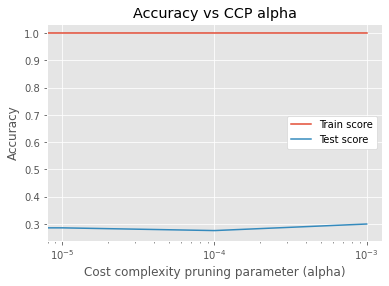

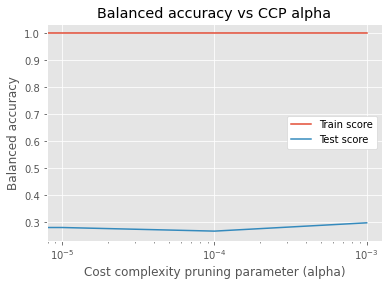

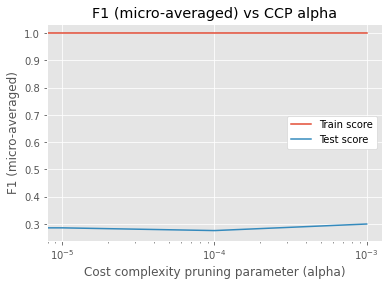

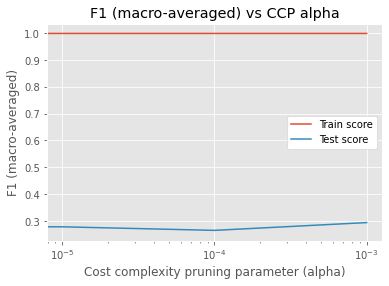

In [0]:
# BOW - Print test and train scores vs alpha

plot_alpha("phase", "decision tree", "BOW")

We can see that the training accuracy is very high (almost 100%), whereas the test accuracy is less than 30%. This suggests that the model does overfit, such that metrics based on the training set are unreliable.

The best alpha selected by K-fold cross-validation is 0.001. In the next cell, we print the cross-validated scores for this optimal alpha.

In [0]:
# BOW - Print CV scores for best alpha

df_cv_scores("phase", "decision tree", "BOW")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_micro,test_f1_macro
0,4.14,0.01,0.26,0.26,0.26,0.25
1,4.20,0.01,0.30,0.29,0.30,0.29
2,4.15,0.01,0.25,0.25,0.25,0.25
3,4.25,0.01,0.26,0.26,0.26,0.26
4,4.10,0.01,0.28,0.25,0.28,0.25
Mean,4.17,0.01,0.27,0.26,0.27,0.26


The table confirms that the mean accuracy is around 27%, which means once more that the model performs poorly.

Next, we replicate the analysis with the tf-idf representation.

In [0]:
## Run decision tree - TFIDF

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Run the function 
  search, cv_scores = nested_cv("phase", "decision tree", "TFIDF")

# Total run time: 36 minutes and 01 seconds

To run the content of this cell, please change the if condition to True.


Best alpha: 0 



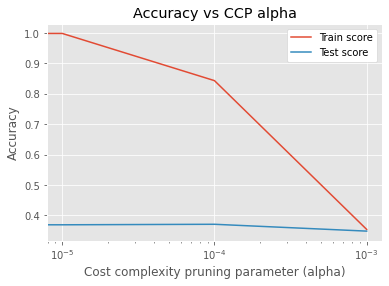

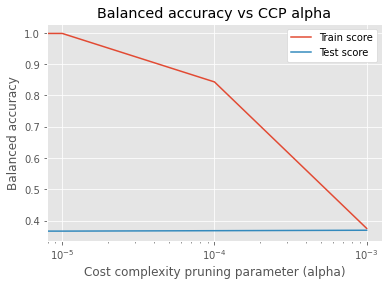

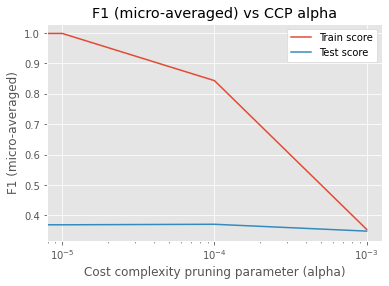

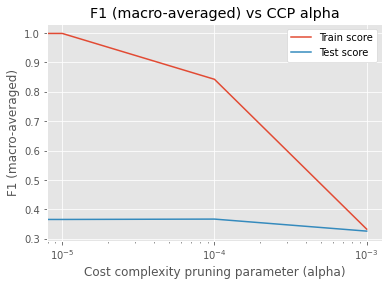

In [0]:
# TFIDF - Print test and train scores vs alpha

plot_alpha("phase", "decision tree", "TFIDF")

We see that the train scores decrease for higher values of alpha, which is what we expect from theory. This suggests that the model tends to overfit for low values of alpha.

However, despite this, the cross-validation procedure selects alpha = 0, which means that no pruning will take place.

Finally, we print the cross-validated scores for alpha = 0.

In [0]:
# TFIDF - Print CV scores for best alpha

df_cv_scores("phase", "decision tree", "TFIDF")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_micro,test_f1_macro
0,335.56,0.29,0.37,0.36,0.37,0.36
1,338.63,0.29,0.37,0.37,0.37,0.37
2,331.34,0.30,0.38,0.37,0.38,0.37
3,345.81,0.30,0.36,0.35,0.36,0.35
4,338.22,0.31,0.38,0.38,0.38,0.38
Mean,337.91,0.30,0.37,0.37,0.37,0.37


We can see that the test accuracy is 37%, much better than the decision tree using bag-of-words. However, this is still relatively low, leading us to consider a third approach: random forest.

### 3.3.3. Random forest

In this part, we implement the random forest classifier, for both the bag-of-words and tf-idf representations.

In the next cell, we call the `nested_cv` function defined in the previous part, with `random forest` as argument. We first focus on the model with the bag-of-words approach.



In [0]:
# Random forest - BOW

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Run the function 
  search, cv_scores = nested_cv("phase", "random forest", "BOW")

# Total run time: 1 hour, 08 minutes and 16 seconds

To run the content of this cell, please change the if condition to True.


Then, we define and call a function which prints the best parameters selected by the randomised search.

In [0]:
 # Random forest - BOW

# Define function to print best parameters

def print_best_params(y_var, clf, method):
  
  # Get search object
  path = directory + 'Output/'
  filename = path + y_var + '_' + clf + '_' + method.lower() + '_search'
  infile = open(filename,'rb')
  search = pickle.load(infile)
  infile.close()

  # Print best parameters
  print("Best parameters:")
  best_params = search.best_params_ 
  for p in best_params.keys():
    print(p + ":", best_params[p])

# Print best params
print_best_params("phase", "random forest", "BOW")

# Return CV scores
print("\nCross-validation scores:")
df_cv_scores("phase", "random forest", "BOW")

Best parameters:
clf__n_estimators: 100
clf__min_samples_split: 2
clf__min_samples_leaf: 2
clf__max_depth: None
clf__ccp_alpha: 0.0001

Cross-validation scores:


,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_micro,test_f1_macro
0,639.37,0.53,0.43,0.42,0.43,0.42
1,639.71,0.52,0.43,0.42,0.43,0.42
2,637.87,0.55,0.44,0.43,0.44,0.42
3,653.37,0.55,0.44,0.43,0.44,0.42
4,662.63,0.52,0.44,0.43,0.44,0.43
Mean,646.59,0.53,0.43,0.42,0.43,0.42


The test accuracy is 43% on average for the best hyperparameters, which is slightly better than for the decision tree.

Next, we perform the same analysis using tf-idf instead of bag-of-words.

In [0]:
# Random forest - TFIDF

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Run the function 
  search, cv_scores = nested_cv("phase", "random forest", "TFIDF") # 1h 19min 53s

# Total run time:

To run the content of this cell, please change the if condition to True.


In [0]:
# Random forest - TFIDF

# Print best parameters
print_best_params("phase", "random forest", "BOW")

# Return CV scores
print("\nCross-validation scores:")
df_cv_scores("phase", "random forest", "BOW")

Best parameters:
clf__n_estimators: 100
clf__min_samples_split: 2
clf__min_samples_leaf: 2
clf__max_depth: None
clf__ccp_alpha: 0.0001

Cross-validation scores:


,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_micro,test_f1_macro
0,639.37,0.53,0.43,0.42,0.43,0.42
1,639.71,0.52,0.43,0.42,0.43,0.42
2,637.87,0.55,0.44,0.43,0.44,0.42
3,653.37,0.55,0.44,0.43,0.44,0.42
4,662.63,0.52,0.44,0.43,0.44,0.43
Mean,646.59,0.53,0.43,0.42,0.43,0.42


The optimal hyperparameters are the same as for the approach using bag-of-words. 
Moreover, the accuracy is 43%, which is similar to the result obtained with a bag-of-words approach.

# 4. Sensitivity analysis

In this section, we explicitly compare the performance of the Naive Bayes, decision tree, and random forest classifiers, for our main prediction task. We aim to answer the research question: *Is it possible to predict the level of government measures using Reddit submissions?* 

Then, we repeat the analysis using alternative dependent variables, and see how the different classifiers perform.

## 4.1. Comparison: Naive Bayes vs decision tree vs random forest

In this subsection, we compare the performance of our three classifiers.

In [0]:
## Display mean scores for different methods to compare

# Create a mean scores dictionary to store mean of CV metrics
mean_scores = dict((key, {}) for key in scores.keys())

def compare_scores(y_var):

  # Get CV metrics
  for clf in ["naive bayes", "decision tree", "random forest"]:
    for method in ["BOW", "TFIDF"]:
      df_cv_scores(y_var, clf, method, get_df = False)

  # Get the mean and put it in mean_scores
  for clf_method in scores[y_var].keys():
    mean_scores[y_var][clf_method] = dict(pd.DataFrame(scores[y_var][clf_method]).mean())

  # Print data frame
  df = pd.DataFrame(mean_scores[y_var]).round(2)
  df = df.loc['test_accuracy':,]
  return(df)

compare_scores("phase")

,naive bayes_bow,naive bayes_tfidf,decision tree_bow,decision tree_tfidf,random forest_bow,random forest_tfidf
test_accuracy,0.35,0.35,0.27,0.37,0.43,0.44
test_balanced_accuracy,0.36,0.36,0.26,0.37,0.42,0.44
test_f1_micro,0.35,0.35,0.27,0.37,0.43,0.44
test_f1_macro,0.34,0.34,0.26,0.37,0.42,0.44


Overall, we can see that the random forest with a tf-idf representation performs best, followed by the random forest with a bag-of-words representation.

The decision tree with tf-idf representation performs only slightly better than the Naive Bayes classifier. Finally, the decision tree with bag-of-words is the worst performing model. 

## 4.2. Alternative target variables

We now repeat the analysis using alternative target variables. 
First, we look at stringency categories, which are defined based on the quartile of the stringency index.
Then, we use the stay-at-home requirements dummy variable.

### 4.2.1. Categories

First, we look at the performance of different models using "categories" as target variable. By construction, the variable is relatively well-balanced, such that accuracy is a useful metric.

In [0]:
## Categories

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Naive Bayes
  cv_scores, coefs, pipe = naive_bayes("category", "BOW") # 0min 46s
  cv_scores, coefs, pipe = naive_bayes("category", "TFIDF") # 0min 46s

  # Decision tree
  search, cv_scores = nested_cv("category", "decision tree", "BOW") # 25 minutes and 48 seconds
  search, cv_scores = nested_cv("category", "decision tree", "TFIDF") # 29 minutes and 52 seconds

  # Random forest
  search, cv_scores = nested_cv("category", "random forest", "BOW") # 53 minuts and 07 seconds
  search, cv_scores = nested_cv("category", "random forest", "TFIDF") # 58 minutes and 53 seconds

To run the content of this cell, please change the if condition to True.


In [0]:
## Compare performance

compare_scores("category")

,naive bayes_bow,naive bayes_tfidf,decision tree_bow,decision tree_tfidf,random forest_bow,random forest_tfidf
test_accuracy,0.34,0.34,0.38,0.37,0.45,0.46
test_balanced_accuracy,0.33,0.34,0.38,0.37,0.45,0.46
test_f1_micro,0.34,0.34,0.38,0.37,0.45,0.46
test_f1_macro,0.32,0.33,0.37,0.36,0.45,0.45


As for the "phases" variable, the random forest performs best, especially using the tf-idf representation, with an accuracy of 46%.

The decision tree comes next, with an accuracy of 38% and 37% for the bag-of-words and tf-idf representations respectively.

Finally, the naive Bayes classifier has an accuracy of 34% for both the bag-of-words and tf-idf approaches.

### 4.2.2. Stay-at-home requirements

We now use a binary variable equal to 1 if there are stay-at-home requirements, and 0 otherwise, as our target variable. Recall that this data set is imbalanced, such that accuracy might not give a reliable picture of the performance of our models. 

Moreover, our cross-validation methods relied on maximising accuracy to choose the hyperparameters. Ideally, we would also want to modify the function to optimise a more adequate metric. 

In [0]:
## Check balance

X, y = get_variables("stay at home")

print("Count:")
print(y.value_counts())

print("\nPercentage:")
print(round(100 * y.value_counts()/len(y), 2))

Count:
0    13588
1     7638
dtype: int64

Percentage:
0    64.02
1    35.98
dtype: float64


As we can see, 64% of the data set is composed by observations with no stay-at-home requirements. Thus, a model which always predicts that the target variable is equal to 0 will have an accuracy of 64%. This shows that accuracy is an unreliable metric in this case.

In [0]:
## Stay-at-home requirements

print("To run the content of this cell, please change the if condition to True.")

if toggle_off:

  # Naive Bayes
  cv_scores, coefs, pipe = naive_bayes("stay at home", "BOW") # 0min 54s
  cv_scores, coefs, pipe = naive_bayes("stay at home", "TFIDF") # 0min 54s

  # Decision tree
  search, cv_scores = nested_cv("stay at home", "decision tree", "BOW") # 33min 57s
  search, cv_scores = nested_cv("stay at home", "decision tree", "TFIDF") # 35min 06s

  # Random forest
  search, cv_scores = nested_cv("stay at home", "random forest", "BOW") # 1h 14min 03s
  search, cv_scores = nested_cv("stay at home", "random forest", "TFIDF") # 1h 21min 47s

To run the content of this cell, please change the if condition to True.


In [0]:
## Compare performance

compare_scores("stay at home")

,naive bayes_bow,naive bayes_tfidf,decision tree_bow,decision tree_tfidf,random forest_bow,random forest_tfidf
test_accuracy,0.62,0.58,0.61,0.60,0.65,0.68
test_balanced_accuracy,0.55,0.56,0.54,0.57,0.57,0.61
test_f1_micro,0.62,0.58,0.61,0.60,0.65,0.68
test_f1_macro,0.55,0.56,0.53,0.57,0.57,0.61


The best model with respect to the four metrics used is the random forest with the tf-idf representation, followed by the random forest with bag-of-words.

Dependending on which metric to prioritise, the naive Bayes classifier or the decision trees come next.

## 4.3. Discussion

Overall, it seems that the random forest (especially with a tf-idf representation) seems to perform best for all three target variables. However, it is also the most computationally expensive model, which took more than an hour to run.

This is followed by either decision trees or naive Bayes classifiers, depending on the specific target variable. Thus, we recommend testing all three models in future applications, and choosing the one that performs best for a given setting.

# 5. Conclusion

This project has explored the relationship between Reddit submissions and the stringency of government measures against coronavirus.

Overall, the predictive power of the three models used (naive Bayes, decision tree, and random forest) is relatively low, with an accuracy of 46% for our preferred model. 

There are two possible explanations of this finding. First, it is possible that the models used are not the best, and other classifiers might have a better performance. Secondly, it might be the case that Redditors simply do not write about coronavirus on Reddit, preferring other discussion topics.

In order to check which explanation is correct, future research could replicate our approach using a news data set, such as the [GDELT television news data set](https://blog.gdeltproject.org/now-live-updating-expanded-a-new-dataset-for-exploring-the-coronavirus-narrative-on-television-news/) or the [GDELT global multilingual online news data set](https://blog.gdeltproject.org/global-multilingual-covid-19-online-news-narrative-dataset-now-updating/). These data sets are built explicitly around mentions of coronavirus, and we therefore expect them to be directly related to the stringency of government measures against coronavirus. If our models perform well on this data set, then it suggests that Redditors tend to prefer other topics. If they do not, it would mean that the models themselves are problematic, and other approaches such as Support Vector Machines (SVM) should be explored.

